# Open images

/home/turtlefox/anaconda3/envs/gliomorph/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


device used : cuda:0
T : tensor(0.9999, device='cuda:0')  S : tensor(0.9764, device='cuda:0')
centre = (tensor(145), tensor(150)), r = 9 and the seg and ball have 249 pixels overlapping


/home/turtlefox/anaconda3/envs/gliomorph/lib/python3.12/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789563135/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


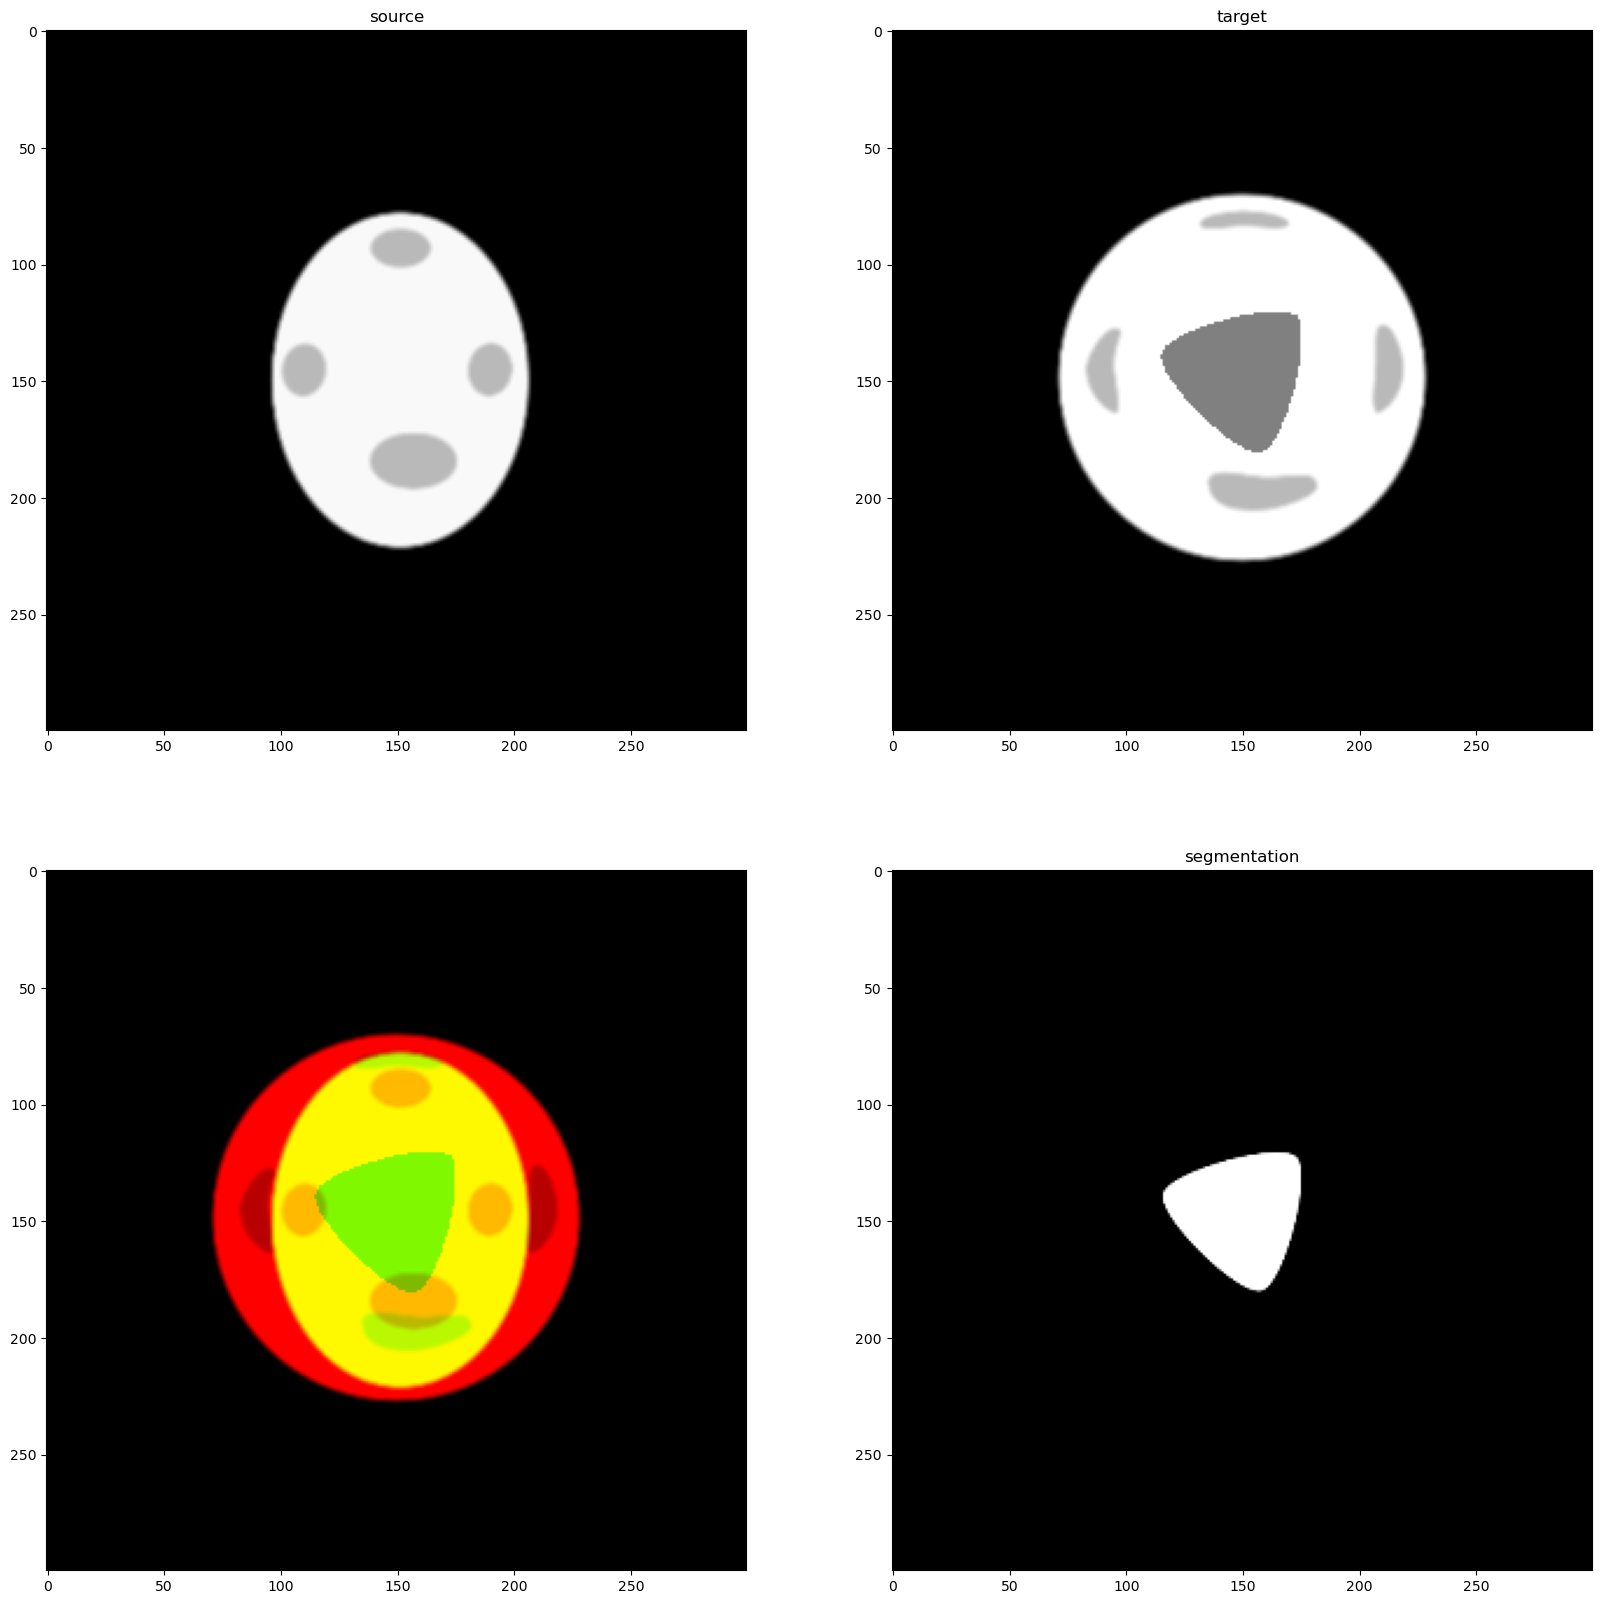

In [1]:
import __init__
import os, sys, time
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16,10)
import torch
import kornia.filters as flt

from  demeter.utils.toolbox import update_progress,format_time
from demeter.utils.reproducing_kernels import get_sigma_from_img_ratio
%load_ext autoreload
%autoreload 2
import demeter.metamorphosis as mt
import demeter.utils.torchbox as tb

cuda = torch.cuda.is_available()
device = 'cpu'
if cuda:
    device = 'cuda:0'
torch.autograd.set_detect_anomaly(False)
print('device used :',device)

# Construction of the toyExample
# Lets load some images
size = (300,300)
source_name,target_name = '23','24'
S = tb.reg_open(source_name,size = size).to(device)   # Small oval with gray dots
T = tb.reg_open(target_name,size = size).to(device)   # Big circle with deformed gray dots
seg = tb.reg_open('21_seg',size=size).to(device)      # rounded triangle

# smooth the images
if True:
    sig = 1
    S = flt.gaussian_blur2d(S,(3,3),(sig,sig))
    T = flt.gaussian_blur2d(T,(3,3),(sig,sig))



#construct the target
if False:
    S = tb.addGrid2im(S,30,method='lines')
    T = tb.addGrid2im(T,30,method='lines')


print('T :',T.max(),' S :',S.max())
## Construct the target image
ini_ball,_ = tb.make_ball_at_shape_center(seg,overlap_threshold=.1,verbose=True)
ini_ball = ini_ball.to(device)
T[seg>0] = 0.5                                       # Add the rounded triangle to the target

source = S
target = T
# mask = mr.mp.image_stock

source_name = 'oval_w_round'
target_name = 'round_w_triangle_p_rd'

kw_img = dict(cmap='gray',vmin=0,vmax=1)
plt.rcParams["figure.figsize"] = (20,20)
fig,ax = plt.subplots(2,2)
ax[0,0].imshow(source[0,0,:,:].cpu().numpy(),**kw_img)
ax[0,0].set_title('source')
ax[0,1].imshow(target[0,0,:,:].cpu().numpy(),**kw_img)
ax[0,1].set_title('target')
ax[1,0].imshow(tb.imCmp(source,target),vmin=0,vmax=1)
ax[1,1].imshow(seg[0,0].cpu().numpy(),**kw_img)
ax[1,1].set_title('segmentation')
plt.show()

# 0./ How to read the plots
For each Experiments successives plots are showed :
 1. __Cost evolution__
    1. With relative coefficients, (i.e.: we plot $\rho \|z_0\|_{L^2}^2$)
    2. Raw values (i.e.: we plot $\|z_0\|_{L_2}^2$)
 2. __Visualisation of the method end product__. We compare the image at the end of the geodesic ($I_1$) with source and target images
 3. __Geodesic evolution visualisation__. Each row represent a given time point, The first collumn is the image evolution ($I_t$), the second show the residuals ($z_t$) and the third the deformation generated by the field $v_t$.
 4. __Deformation visualisation.__ In this series of plot we show the quality of the end deformation $\Phi = \int_0^1 v_t dt; v_0 = Id$
     1. Deformation grid of $\Phi$
     2. Quiver plot of $\Phi$
     3. (4 images) Comparison of the image deformed by $\Phi$ with the source and target images.


# 1./ Classical methods : LDDMM and Metamorphosis

Before demonstrating the Weighted Metamorphosis results, lets show how LDDMM and the classical Methamorphosis behave on this toy examples.

## 1.a. LDDMM

We solve the cost:
$$H(z_0) =   \frac 12\| I_{1} - T \|_{L_2}^2 + \lambda  \|v_0\|^2_V $$
with $I_1$ begin integrated from the geodesic system :
$$
\left\{
\begin{array}{rl}
    v_t &= - K \star  (z_t \nabla I_t)\\
    \dot  z_t &= -\quad \nabla \cdot (z_t v_t)  \\
    \dot I_t &= - \left< \nabla I_t,v_t\right>
\end{array}
\right.
$$

In [58]:
sigma= [(1,1),(5,5),(10,10),(30,30)]
# sigma = get_sigma_from_img_ratio(source.shape,30)
# sigma = tuple([ sig /float(max(source.shape)) for sig in sigma])
print("sigma",sigma)
cost_cst = .0001
integration_step,n_iter,grad_coef = (5,150,0.0001)
residuals = 0
start = time.time()
mr_lddmm = mt.lddmm(source,target,residuals,sigma,cost_cst,
                    integration_step,n_iter,grad_coef,
                    safe_mode=False,
                    dx_convention='square'
                   )
end = time.time()
print("\nComputation done in ",format_time(end - start)," s")

sigma [(1, 1), (5, 5), (10, 10), (30, 30)]
sigma :  (1, 1)
sigma :  (5, 5)
sigma :  (10, 10)
sigma :  (30, 30)
Progress: [##########] 100.00% Done...  ,  345.27).
 (ssd :  ,  344.92).
Computation of forward done in  0:00:04s and 0.835cents  s

Computation of lddmm done in  0:00:04s and 0.846cents  s

Computation done in  0:00:04s and 0.846cents  s


(<Figure size 1500x2500 with 25 Axes>,
 array([[<Axes: title={'center': 't = 0.0'}>, <Axes: >,
         <Axes: title={'center': 'diffeo = tensor(True)'}>],
        [<Axes: title={'center': 't = 0.2'}>, <Axes: >,
         <Axes: title={'center': 'diffeo = tensor(True)'}>],
        [<Axes: title={'center': 't = 0.5'}>, <Axes: >,
         <Axes: title={'center': 'diffeo = tensor(True)'}>],
        [<Axes: title={'center': 't = 0.7'}>, <Axes: >,
         <Axes: title={'center': 'diffeo = tensor(True)'}>],
        [<Axes: title={'center': 't = 1.0'}>, <Axes: >,
         <Axes: title={'center': 'diffeo = tensor(True)'}>]], dtype=object))

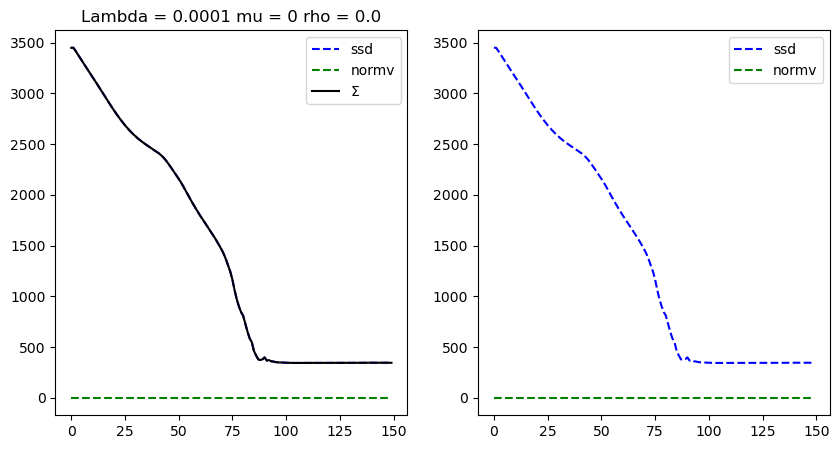

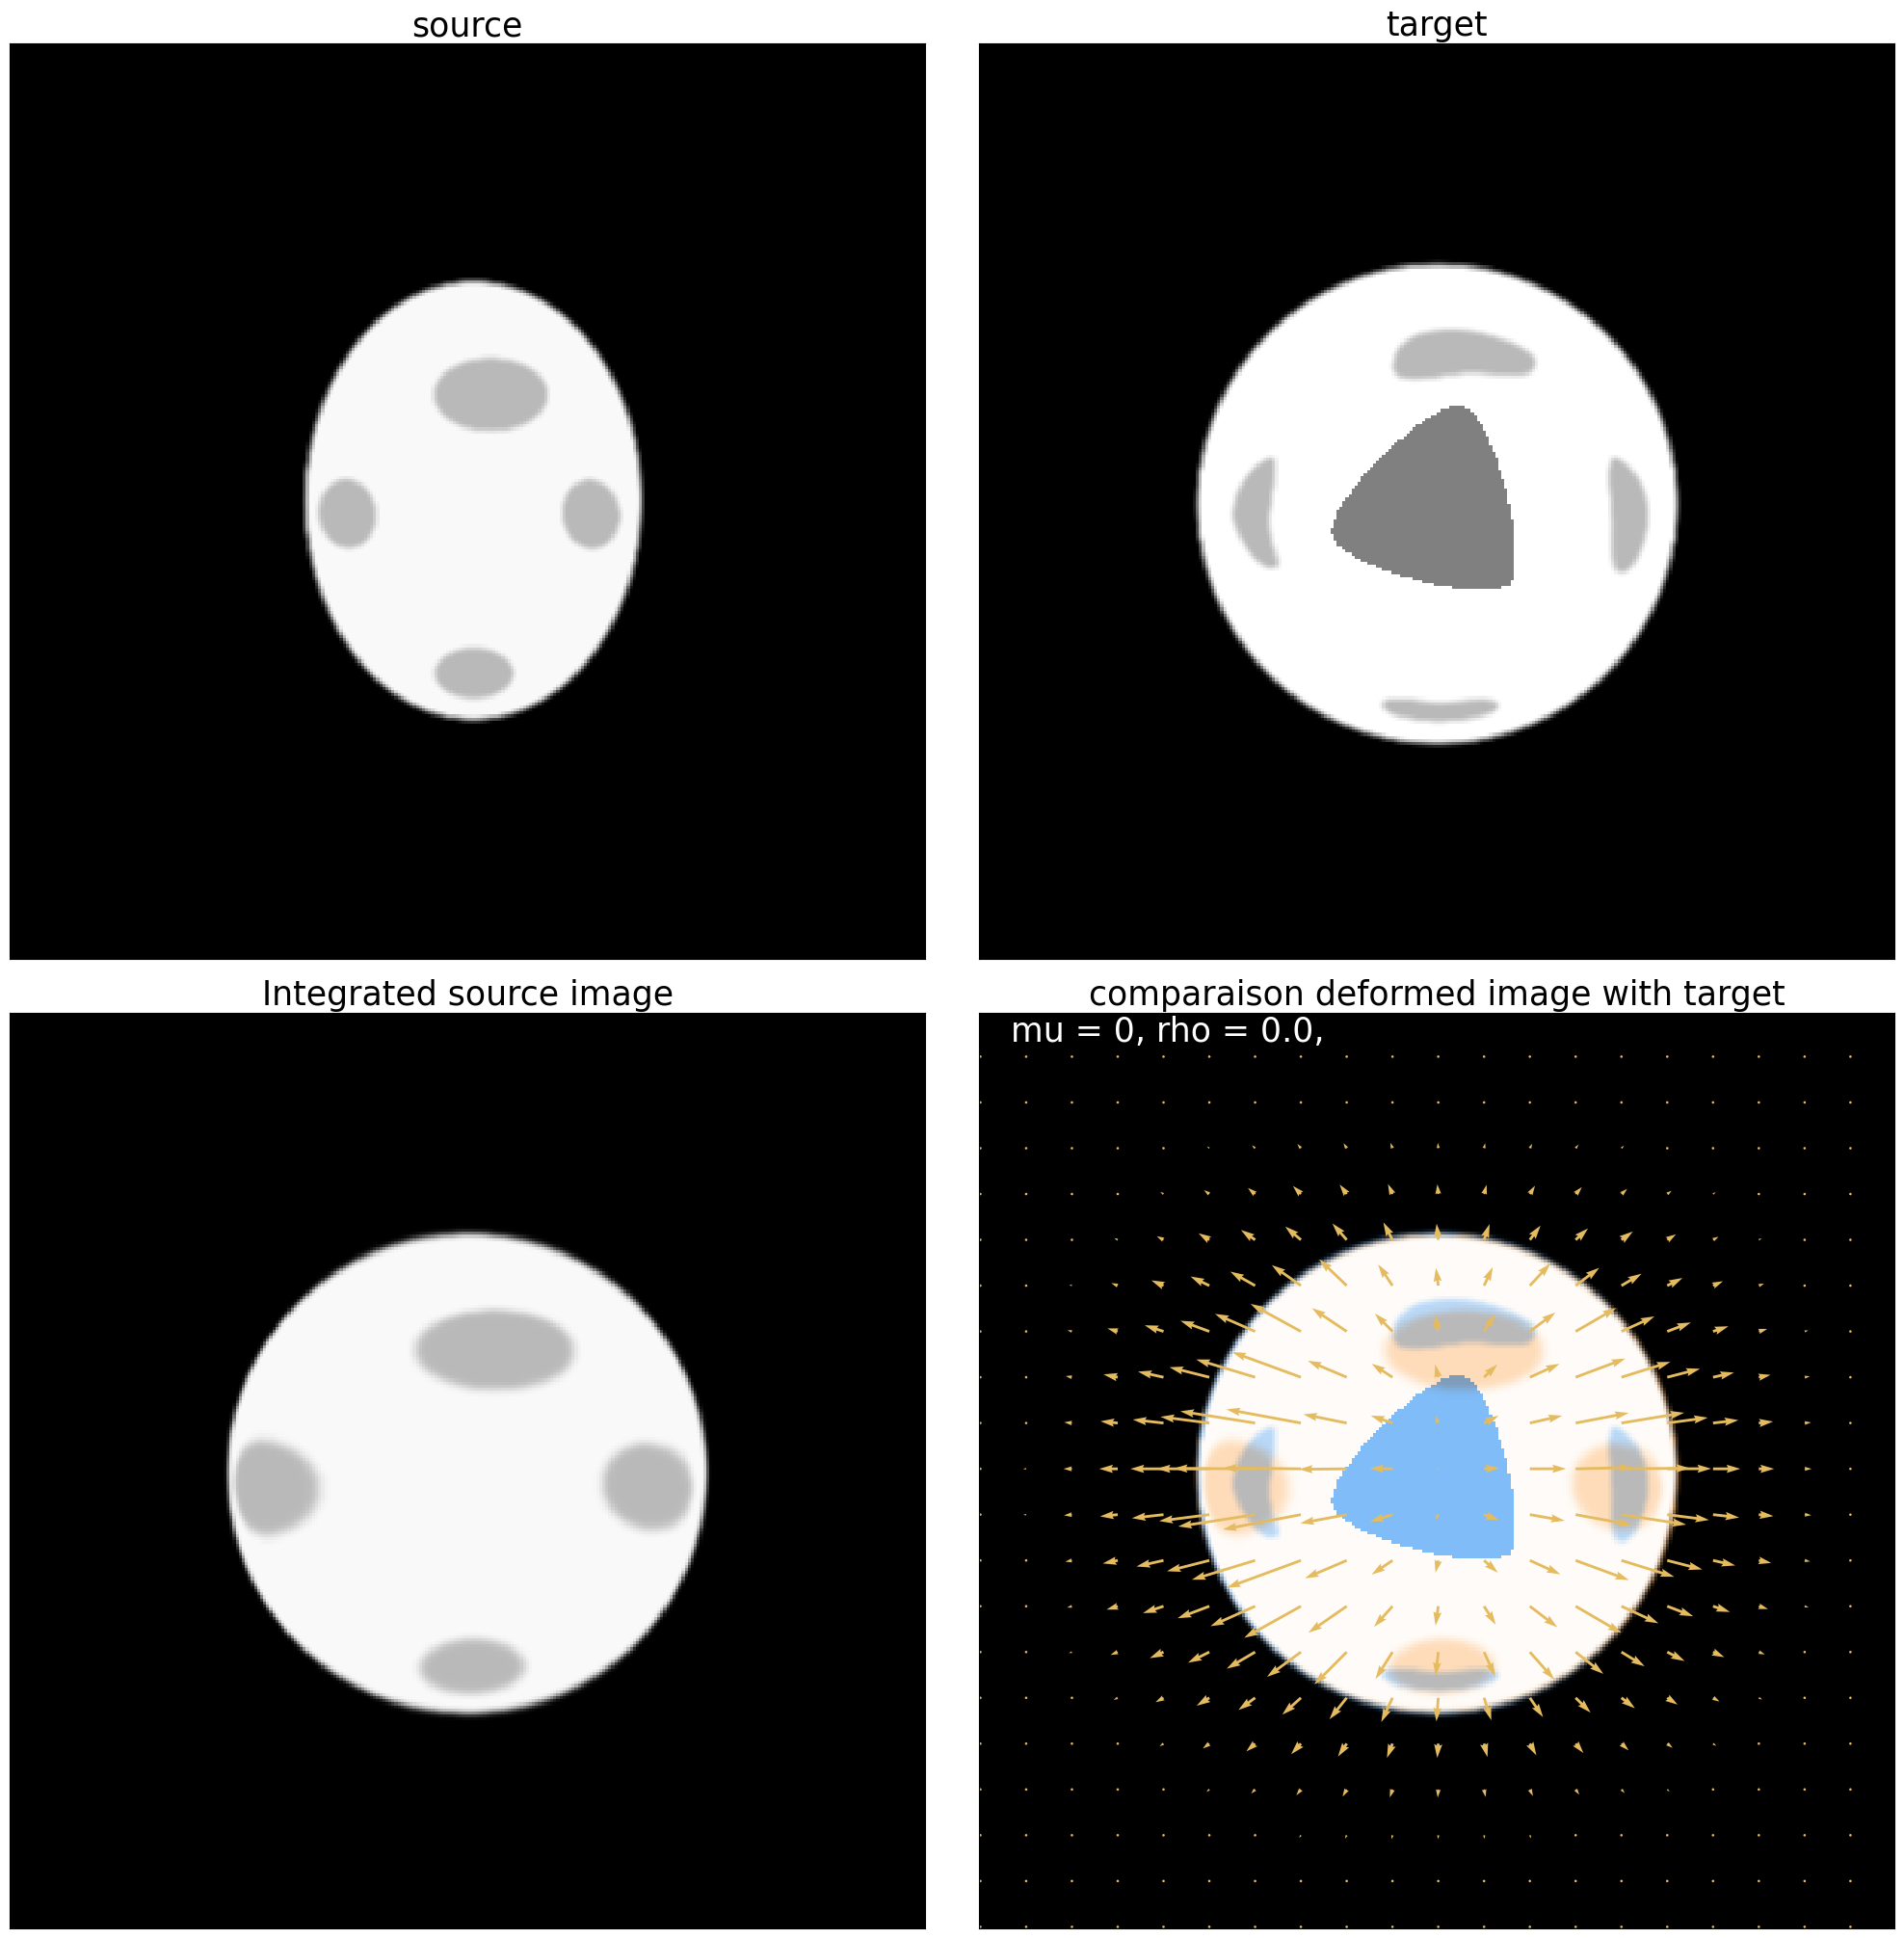

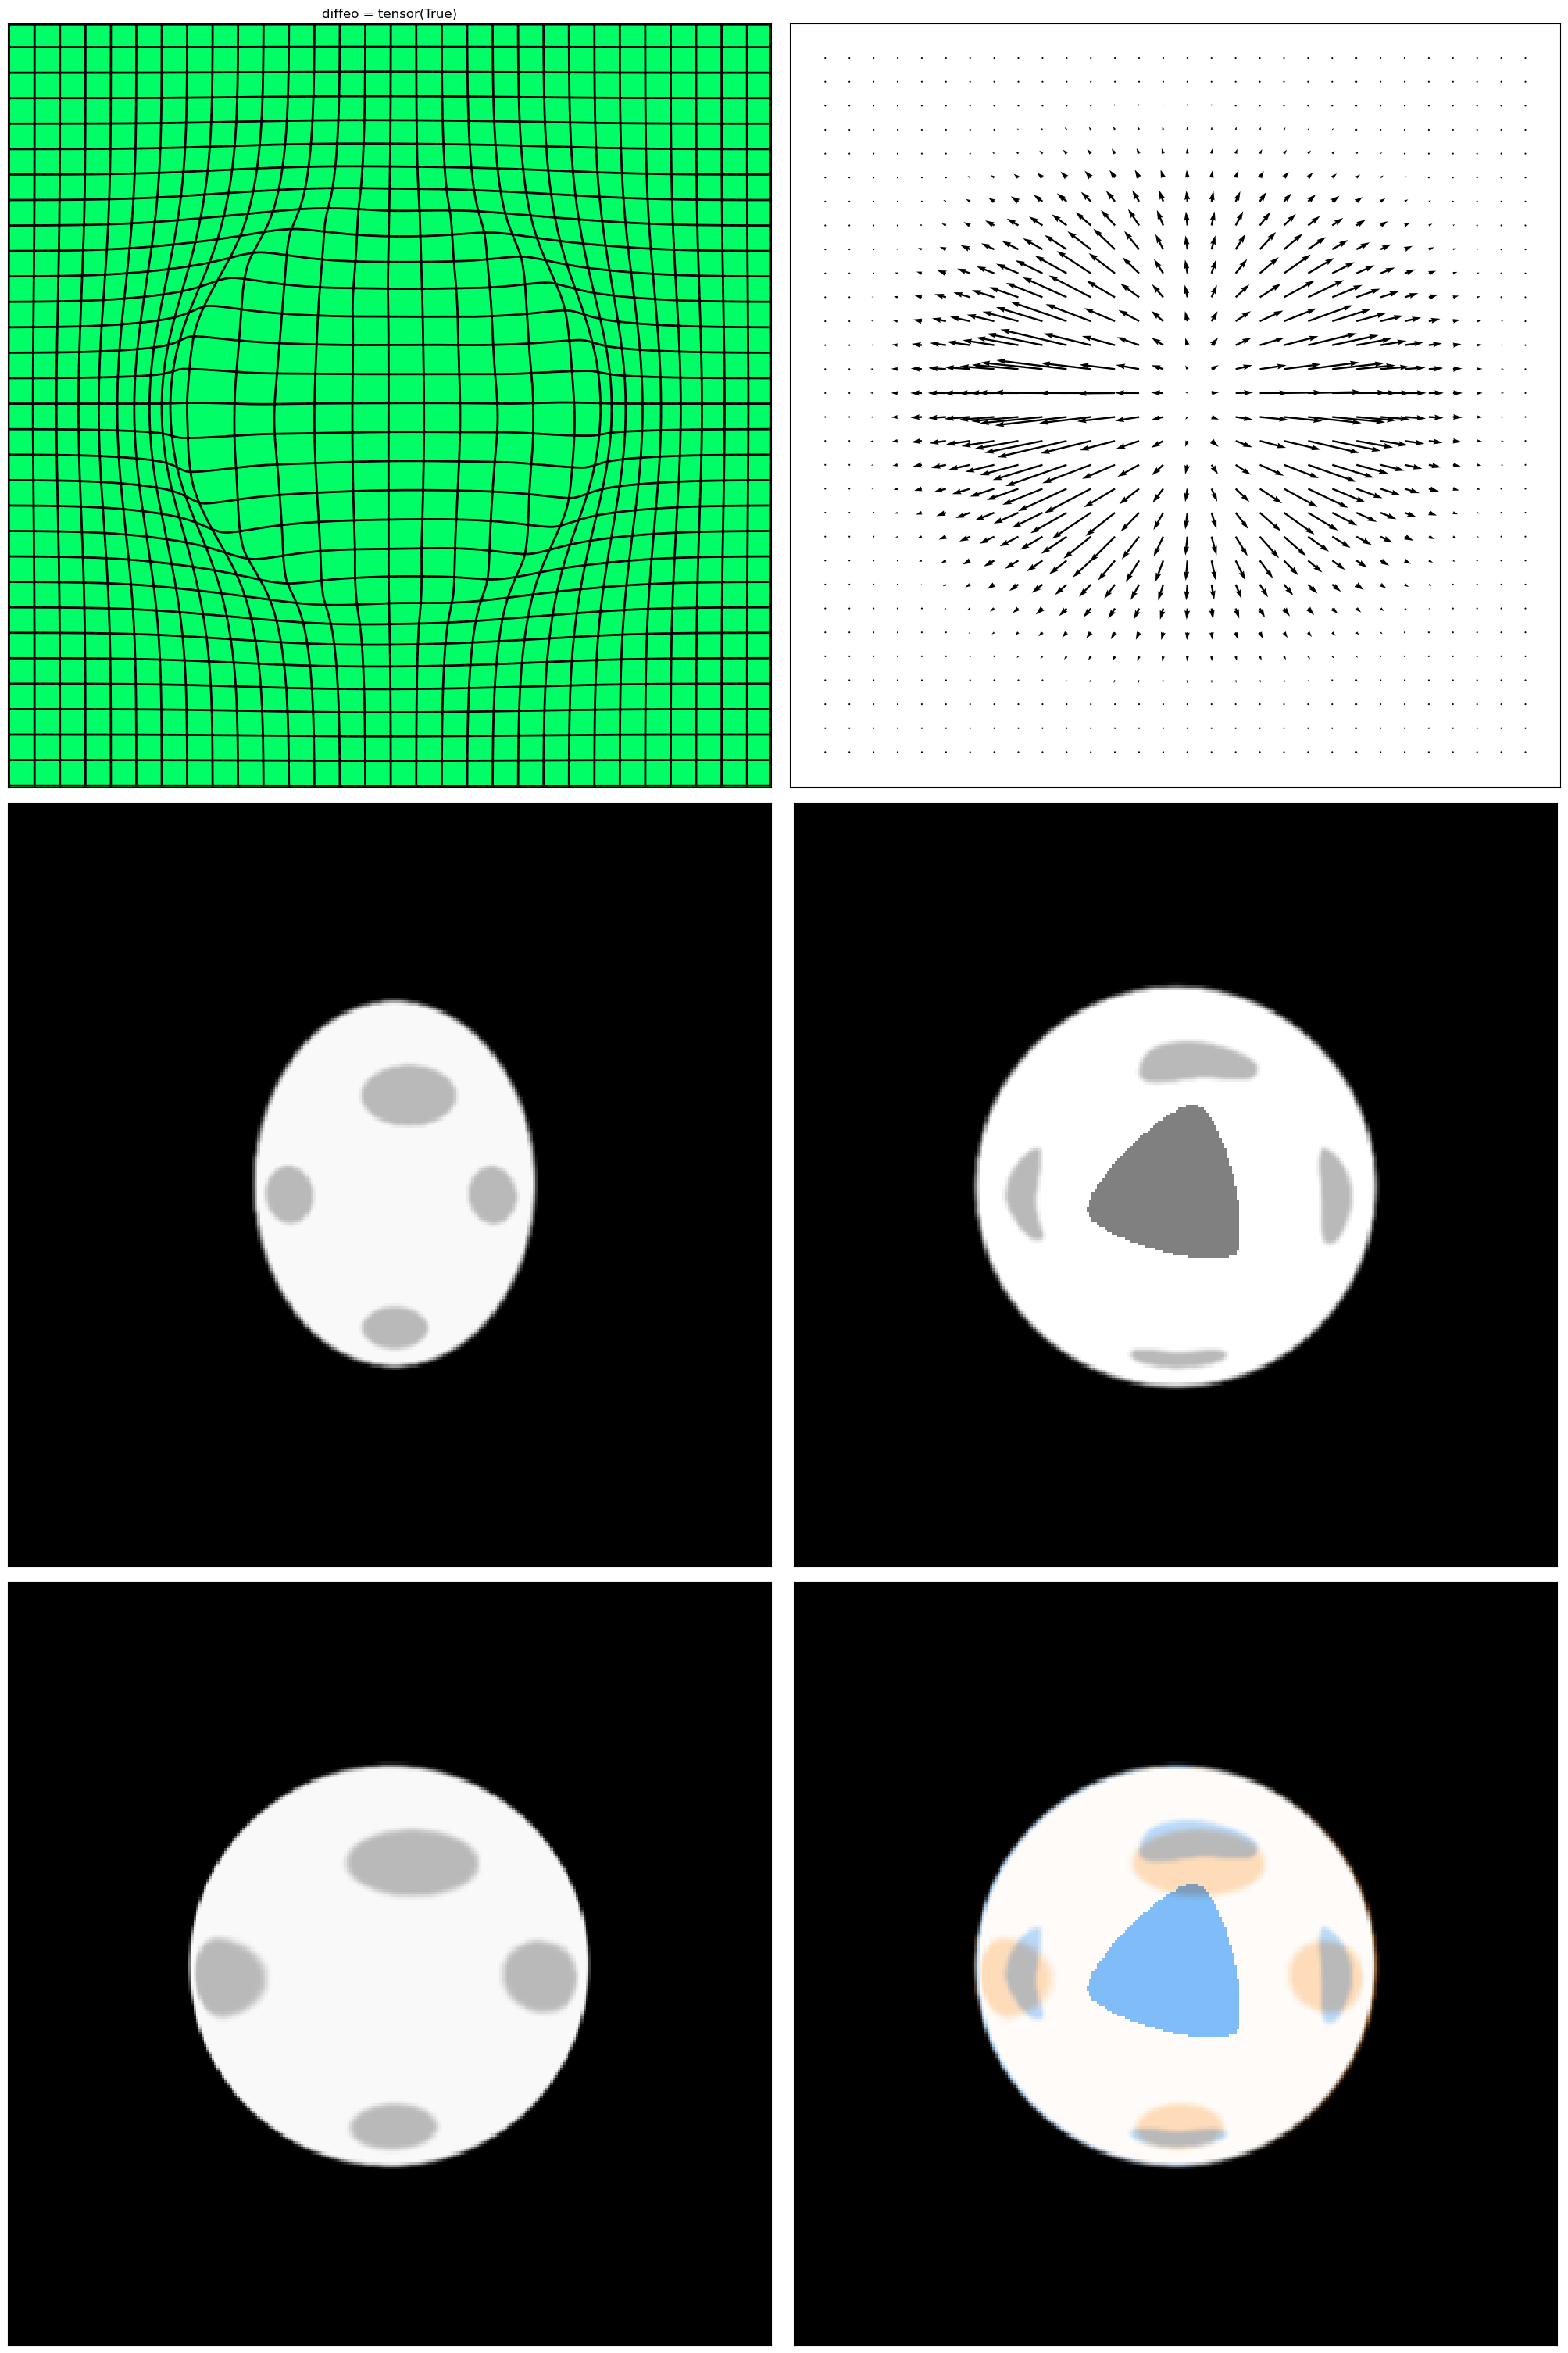

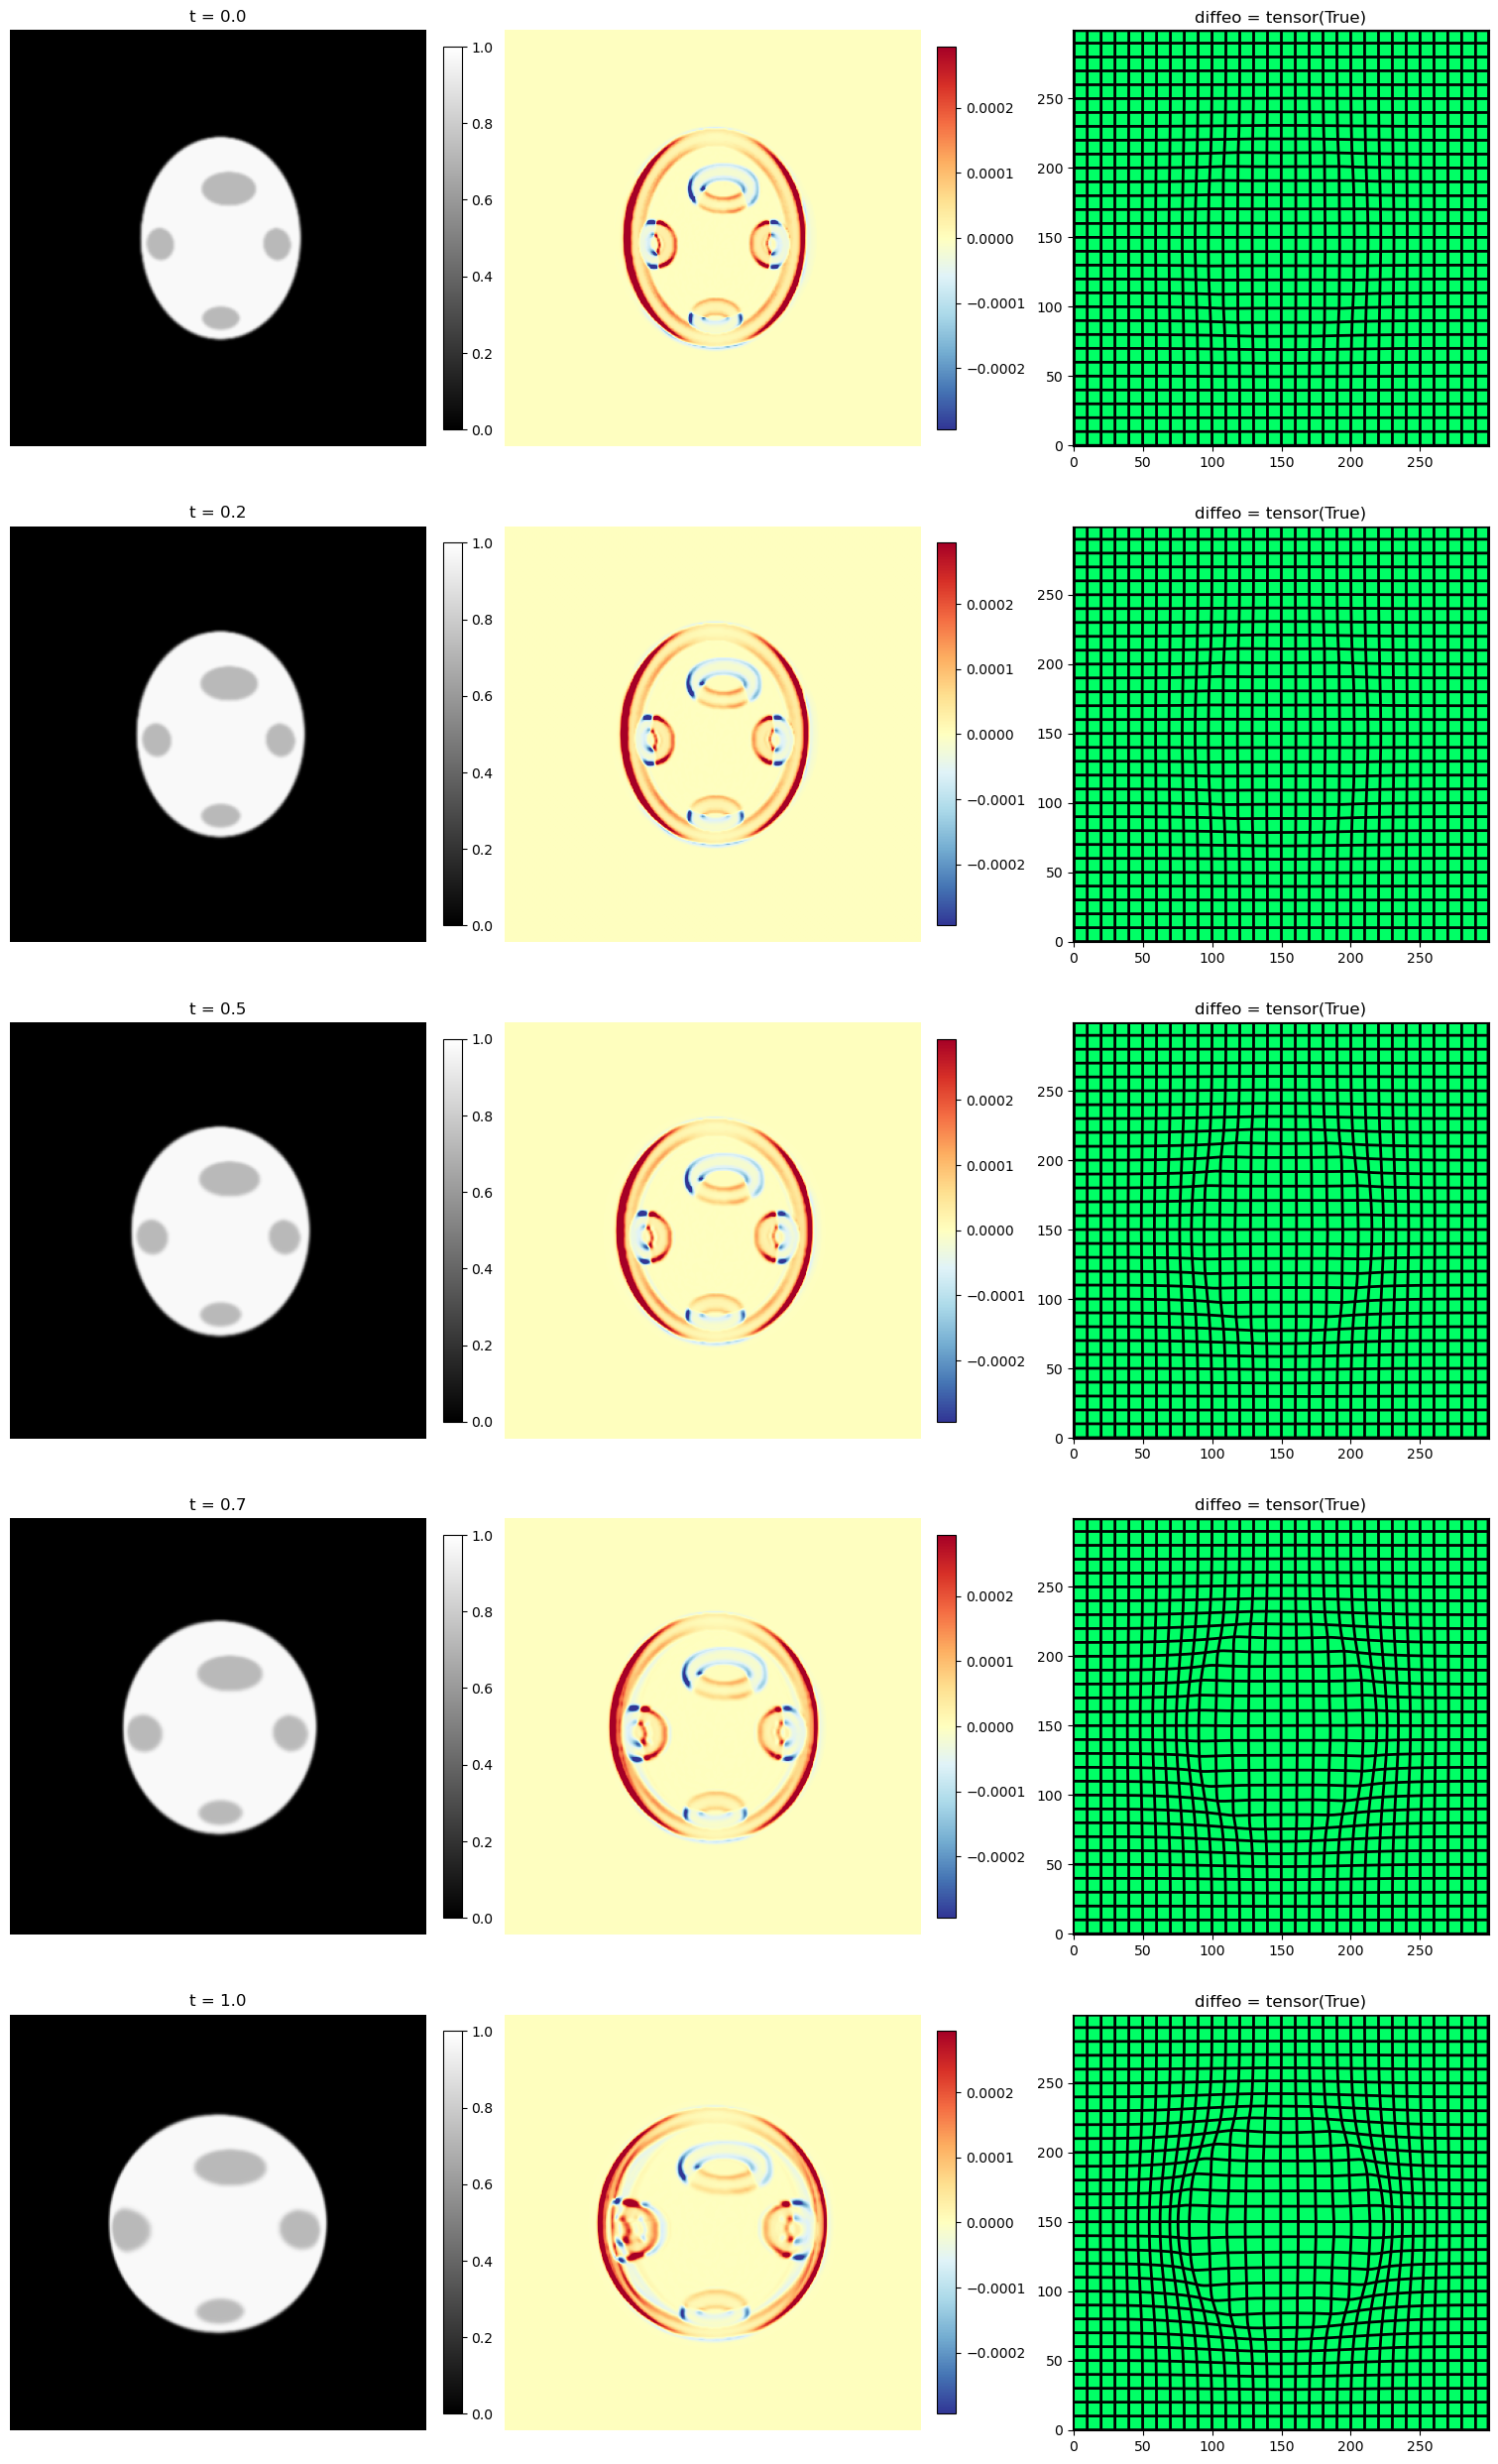

In [59]:
mr_lddmm.plot()
mr_lddmm.plot_deform()
mr_lddmm.mp.plot()

Annimation :
<img src="gifs/playExample_LDDMM.gif" width="500" align="center">

## 1.b Metamorphosis

We solve the cost:
$$H(z_0) =   \frac 12\| I_1 - T \|_{L_2}^2 + \lambda \Big[ \|v_0\|^2_V + \rho \|z_0\|^2_{L_2} \Big]$$

with $I_1$ begin integrated from the geodesic system :
$$
\left\{
\begin{array}{rl}
    v_t &= - \frac{\rho}{\mu} K \star  (z_t \nabla I_t)\\
    \dot  z_t &= -\quad \nabla \cdot (z_t v_t)  \\
    \dot I_t &= - \left< \nabla I_t,v_t\right> + \mu z_t
\end{array}
\right.
$$


In [68]:
sigma = get_sigma_from_img_ratio(source.shape,30)
# sigma = tuple([ sig /float(max(source.shape)) for sig in sigma])
print("sigma",sigma)

# mu = 300 # only photometric differences
mu,rho,lamb = (150,1,1)
integration_step,n_iter,grad_coef = (10,100,1e-2)
residuals = 0
residuals = mr_meta.to_analyse[0].clone().to(device)
mr_meta = mt.metamorphosis(source,target,residuals,mu,rho,sigma,lamb,
                    integration_step,n_iter,grad_coef,
                    safe_mode=False,
                    dx_convention='square',
                    optimizer_method='LBFGS_torch',
                    # optimizer_method='adadelta',                           
)

print(f"image min/max : {mr_meta.mp.image.min(),mr_meta.mp.image.max()}")

sigma (10.729830131446736, 10.729830131446736)
Progress: [##########] 100.00% Done...  ,    0.29).
 (ssd :  ,    0.29).
Computation of forward done in  0:01:50s and 0.378cents  s

Computation of metamorphosis done in  0:01:50s and 0.379cents  s
image min/max : (tensor(-0.0141, device='cuda:0'), tensor(1.0364, device='cuda:0'))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.014148011803627014..1.0364302396774292].


(<Figure size 1500x2500 with 25 Axes>,
 array([[<Axes: title={'center': 't = 0.0'}>, <Axes: >,
         <Axes: title={'center': 'diffeo = tensor(True)'}>],
        [<Axes: title={'center': 't = 0.2'}>, <Axes: >,
         <Axes: title={'center': 'diffeo = tensor(True)'}>],
        [<Axes: title={'center': 't = 0.4'}>, <Axes: >,
         <Axes: title={'center': 'diffeo = tensor(True)'}>],
        [<Axes: title={'center': 't = 0.7'}>, <Axes: >,
         <Axes: title={'center': 'diffeo = tensor(True)'}>],
        [<Axes: title={'center': 't = 1.0'}>, <Axes: >,
         <Axes: title={'center': 'diffeo = tensor(True)'}>]], dtype=object))

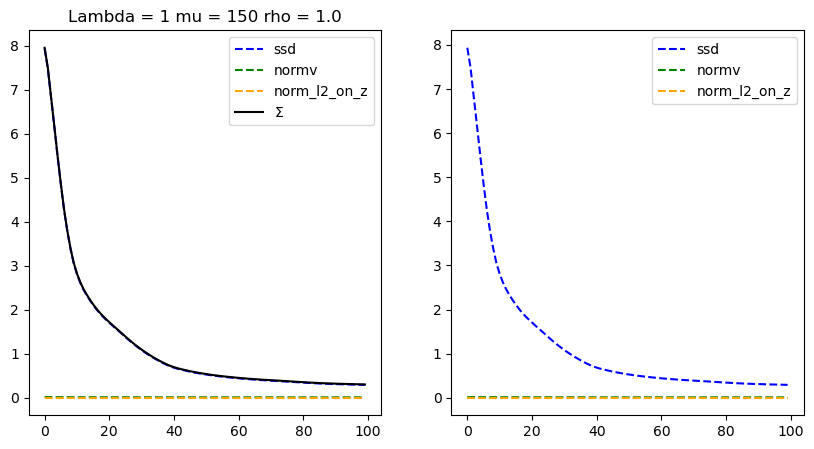

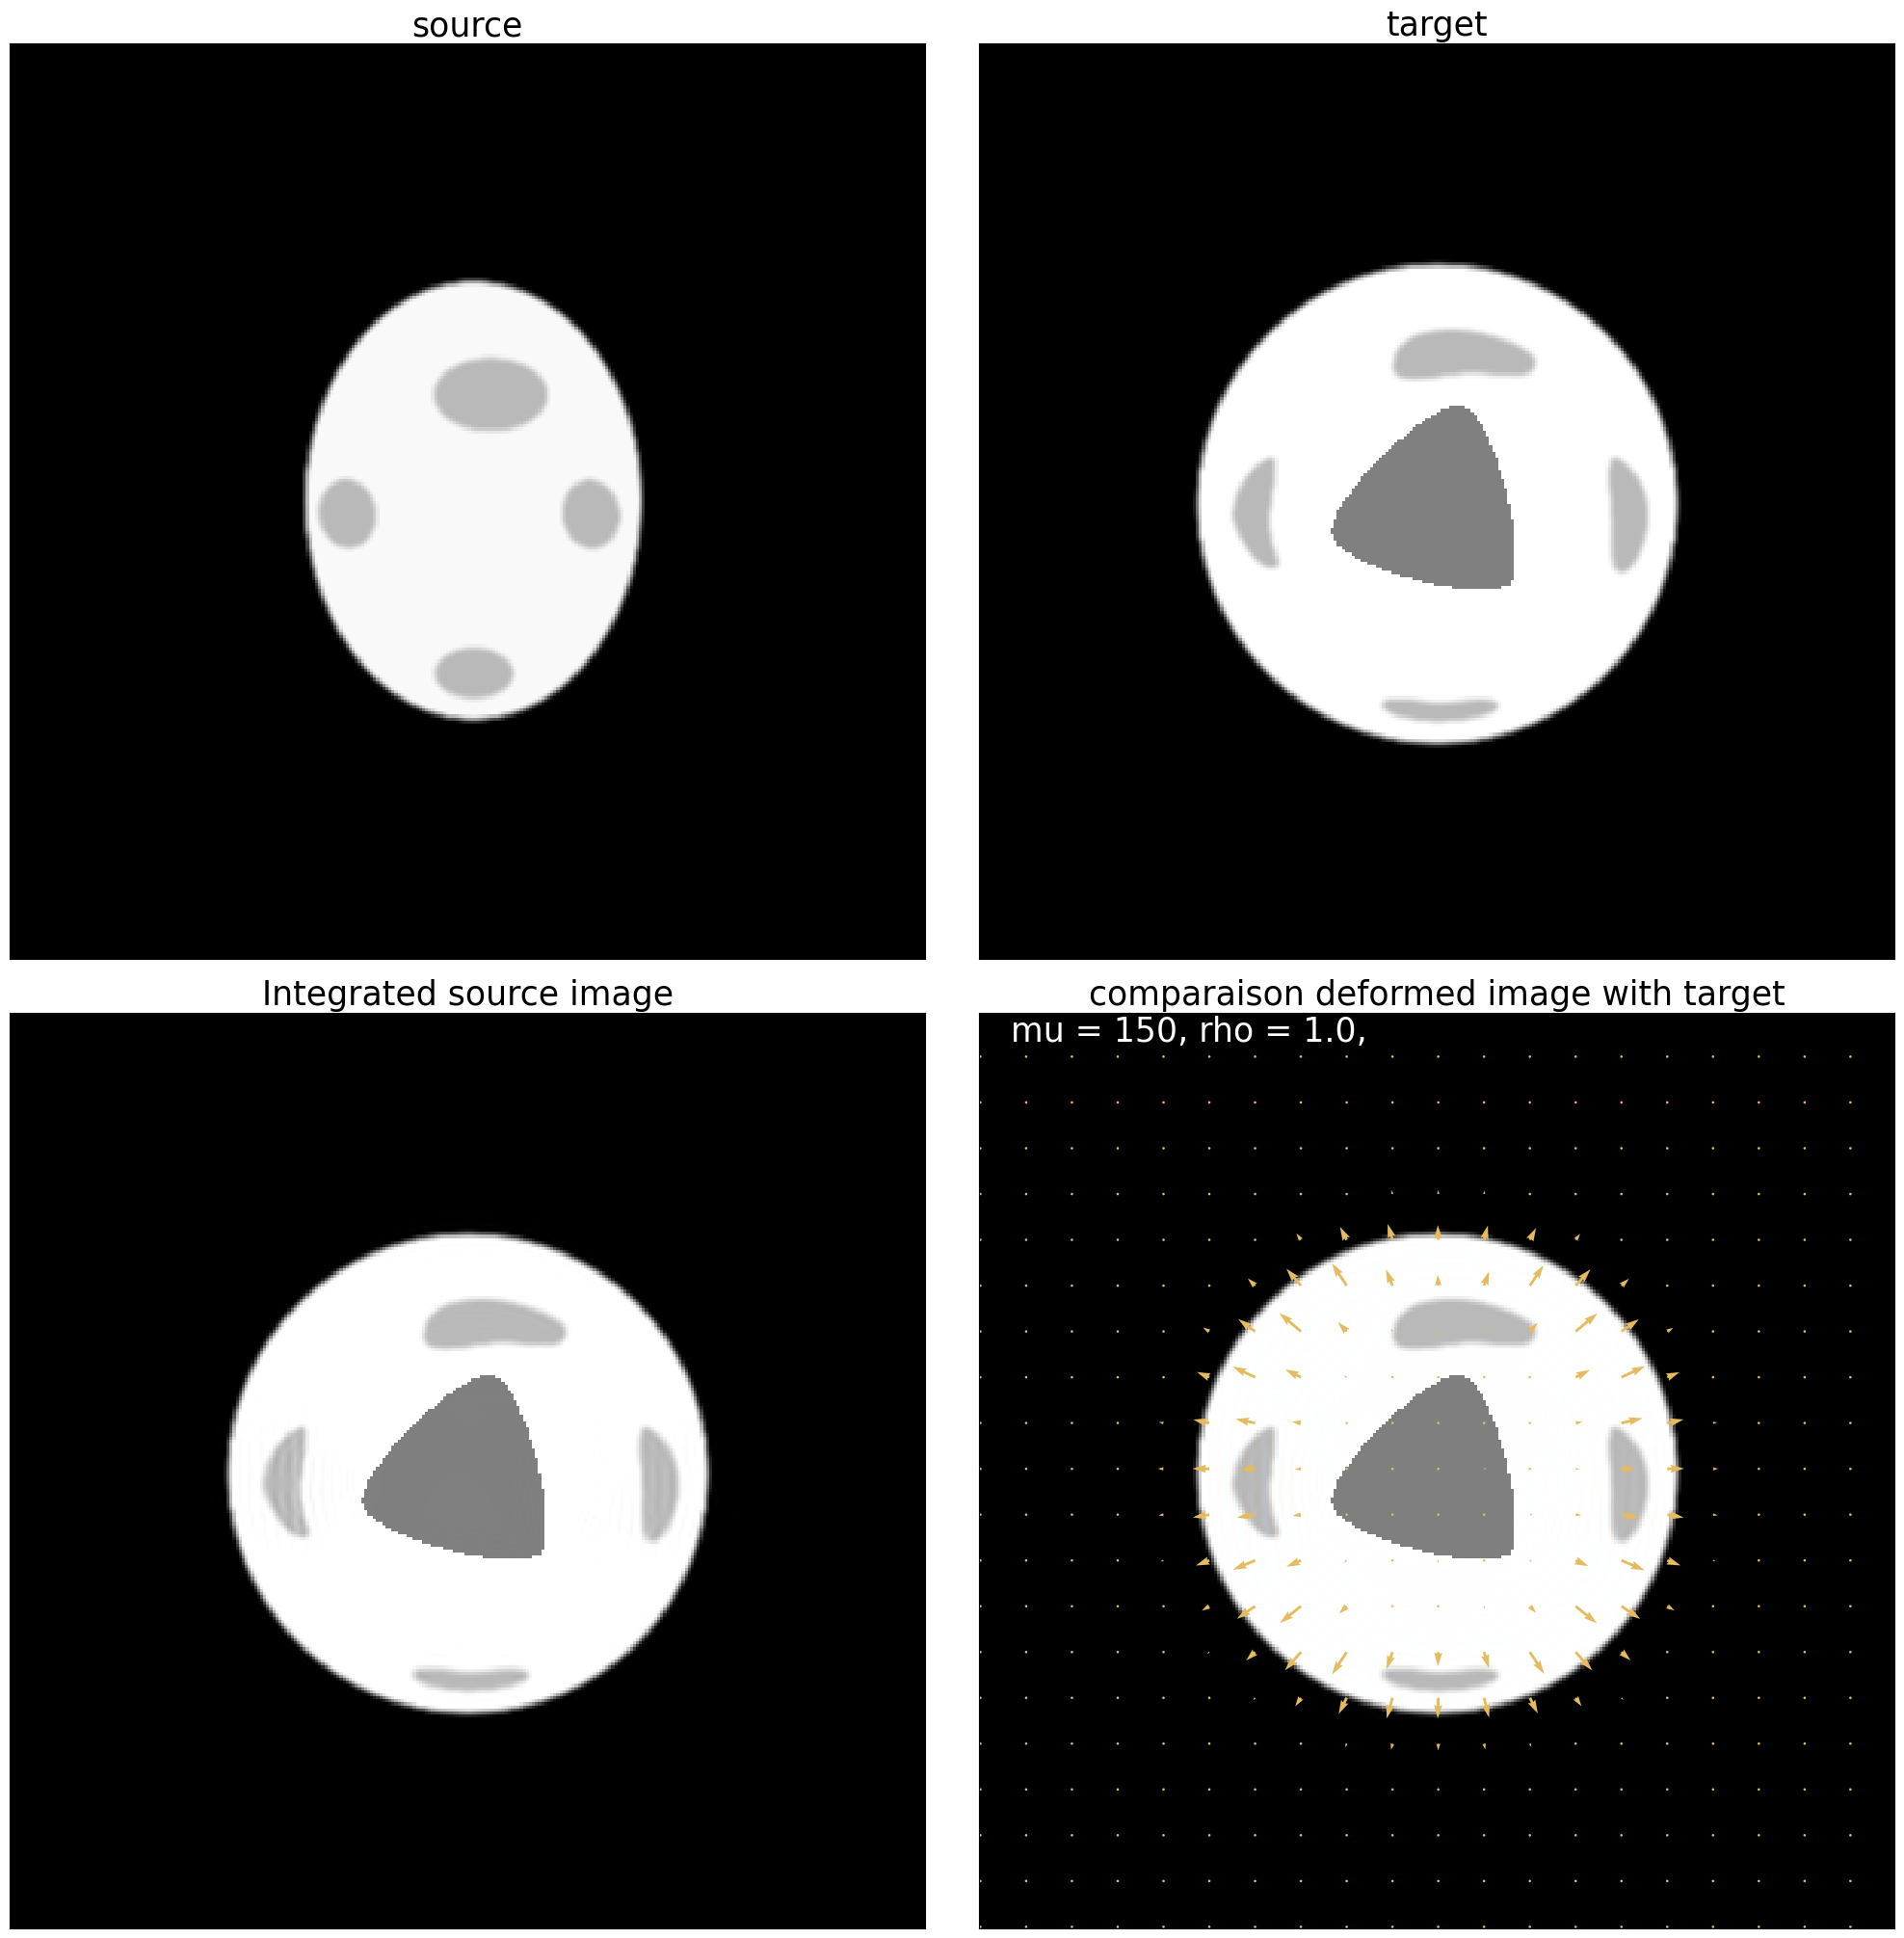

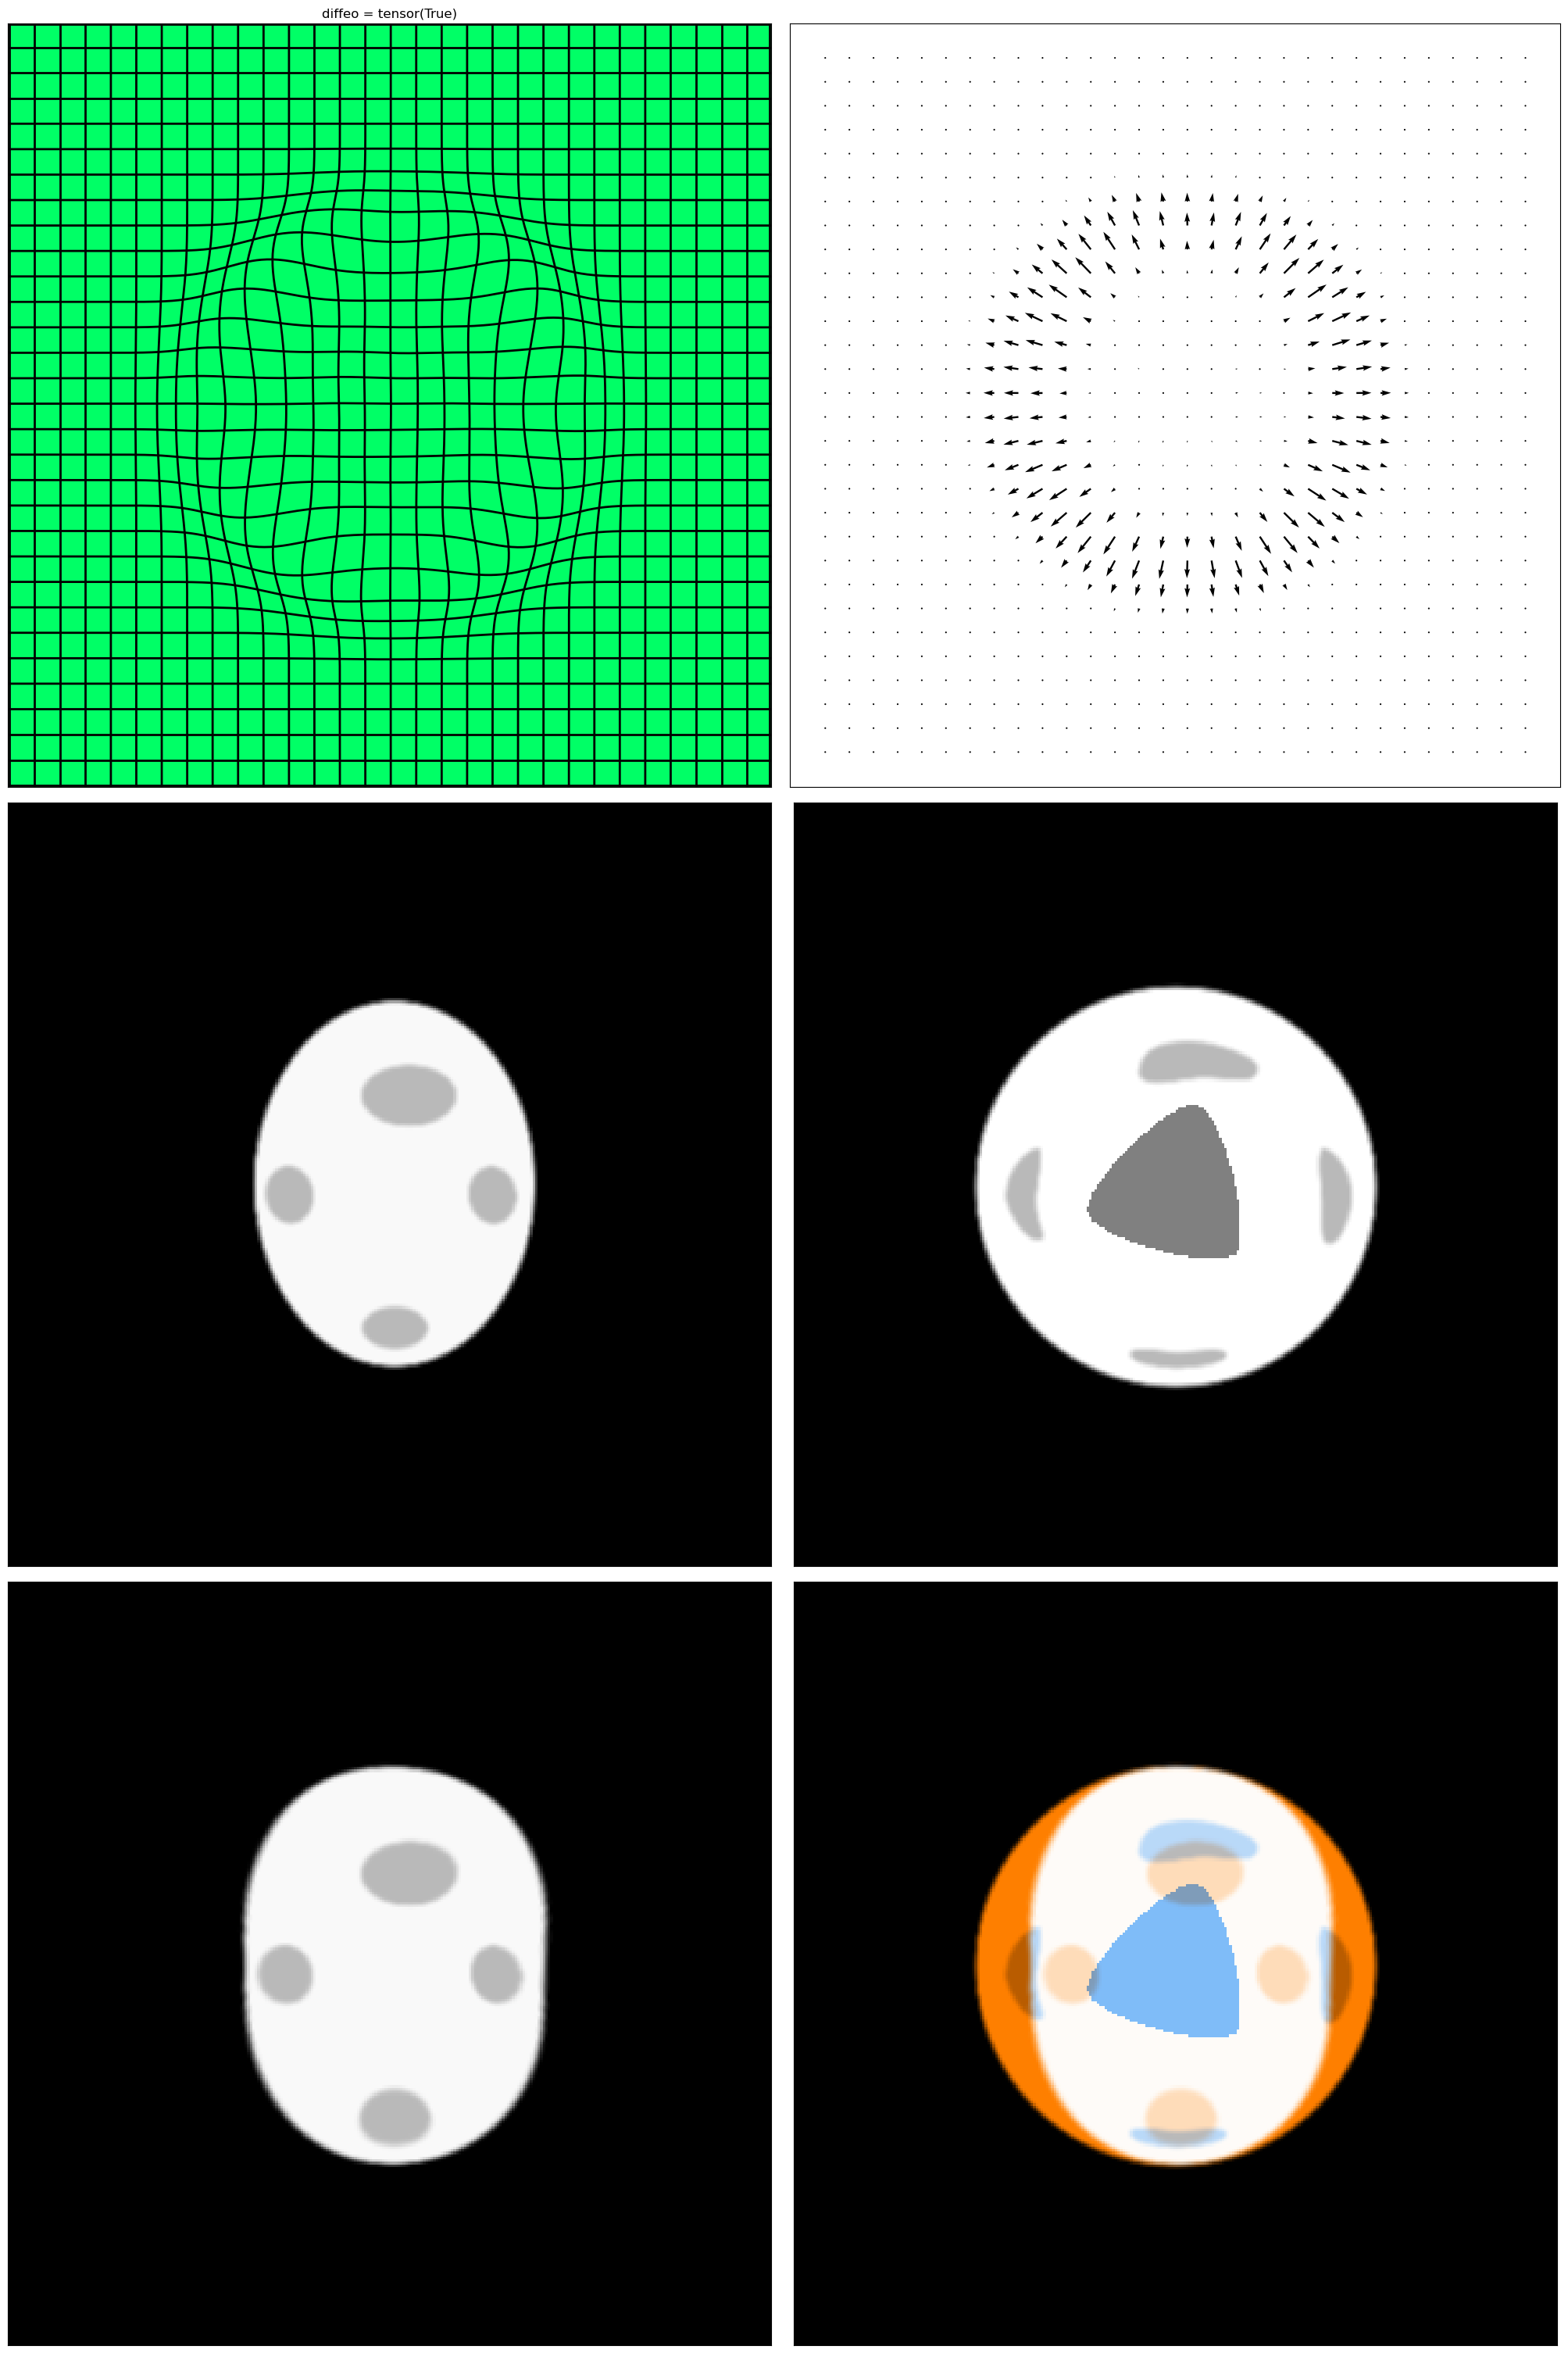

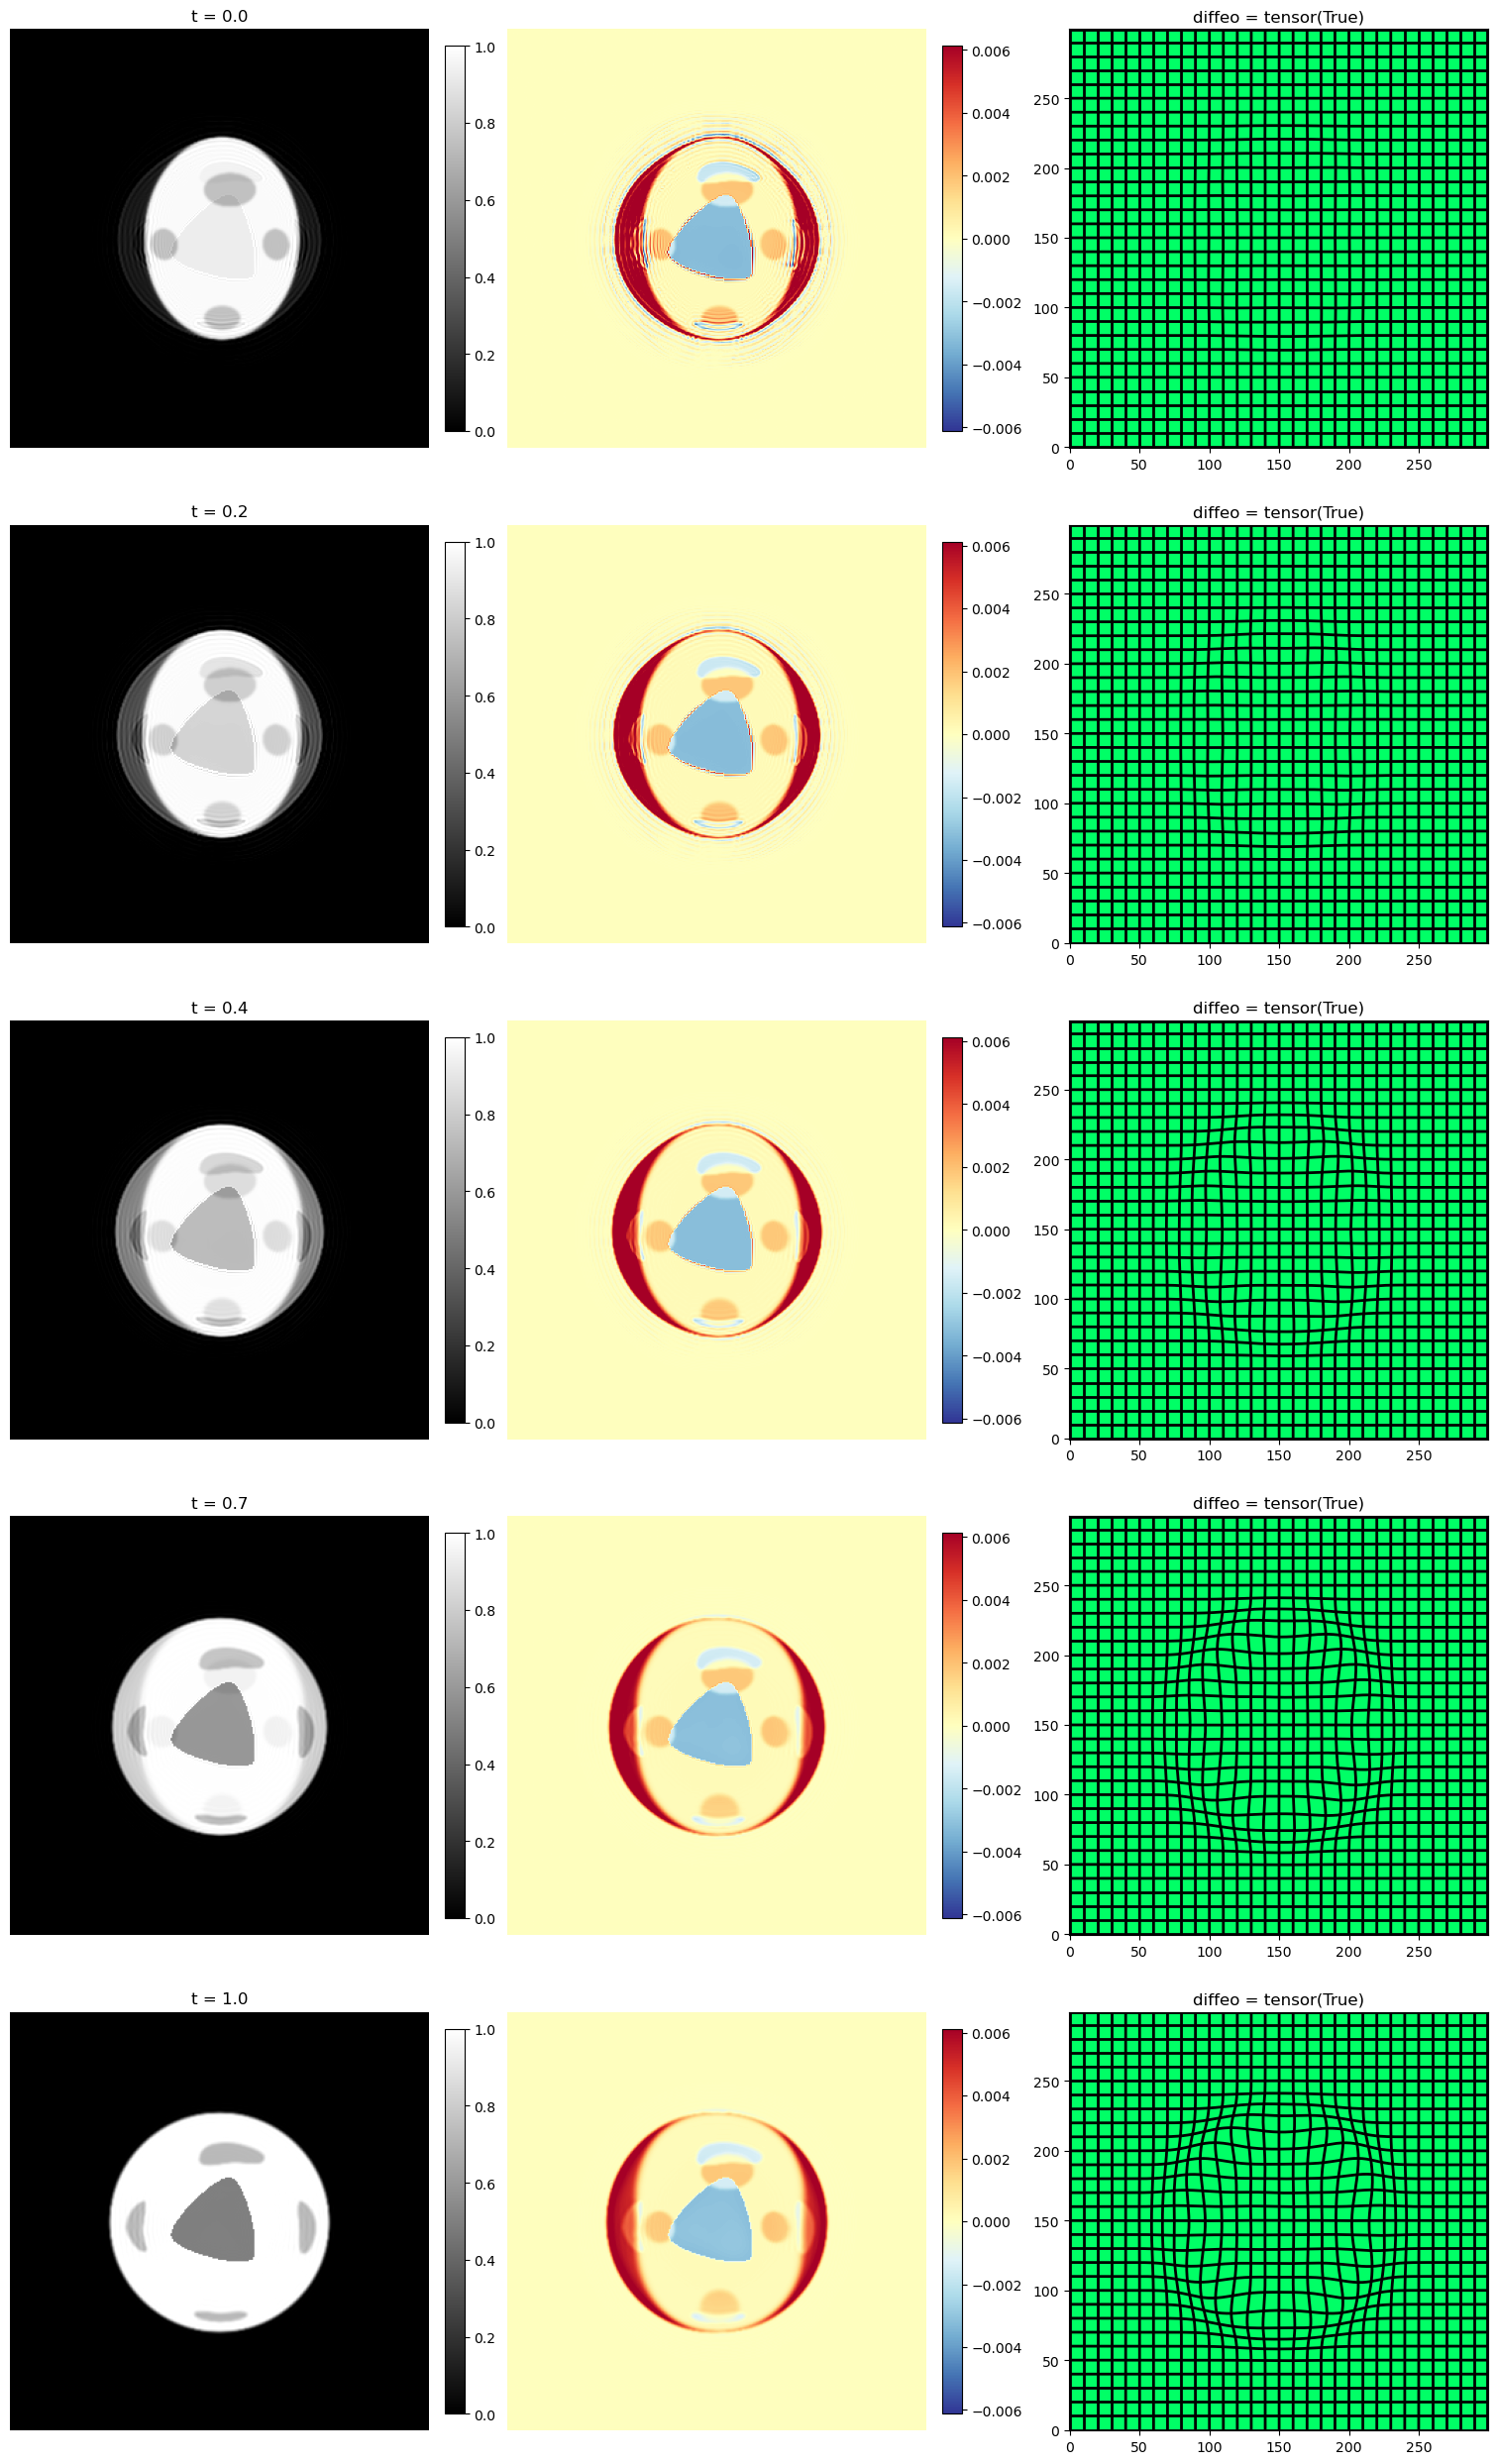

In [69]:
mr_meta.plot(y_log=False)
mr_meta.plot_deform()
mr_meta.mp.plot()

Annimation :
<img src="gifs/playExample_Meta.gif" width="500" align="center">




# 2./ Weighted Metamorphoses.



## 2.a./ Weighted Metamorphosis with constant mask

In this sub-section we set $\forall t \in [0,1], M_t = M_1$ where $M_1$ is the segmentation mask.

We solve the cost:
$$H(z_0) =   \frac 12\| I_1 - T \|_{L_2}^2 + \lambda \Big[ \|v_0\|^2_V + \rho \|\sqrt{M_0}z_0\|^2_{L_2} \Big]$$

with $I_1$ begin integrated from the geodesic system :
$$
\left\{
\begin{array}{rl}
    v_t &= - \frac{\rho}{\mu} K \star  (z_t \nabla I_t)\\
    \dot  z_t &= -\quad \nabla \cdot (z_t v_t)  \\
    \dot I_t &= - \left< \nabla I_t,v_t\right> + \mu z_t
\end{array}
\right.
$$


In [56]:
# sigma = get_sigma_from_img_ratio(source.shape,[[30,30],[40,40]])
# sigma = tuple([ sig /float(max(source.shape)) for sig in sigma])
sigma= [(1,1),(5,5),(10,10),(30,30)]
print("sigma",sigma)

cst_mask = seg.repeat(10,1,1,1)
mu,rho,lamb= (100,1,.0001)
n_iter,grad_coef = (300,5e-2)
residuals = 0
start = time.time()
mr_wm = mt.weighted_metamorphosis(source,target,residuals,cst_mask,
                    mu,rho,'identity',sigma,lamb,
                    n_iter,grad_coef,
                    safe_mode=False,
                    dx_convention='square',
                    # optimizer_method='LBFGS_torch'
)

end = time.time()
print("\nComputation done in ",format_time(end - start)," s")

sigma [(1, 1), (5, 5), (10, 10), (30, 30)]
sigma :  (1, 1)
sigma :  (5, 5)
sigma :  (10, 10)
sigma :  (30, 30)
None
Weighted
not oriented
Progress: [##########] 100.00% Done...  ,   53.98).
 (ssd :  ,   54.80).
Computation of forward done in  0:00:18s and 0.225cents  s

Computation of weighted_metamorphosis done in  0:00:18s and 0.228cents  s

Computation done in  0:00:18s and 0.228cents  s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1401348114013672].


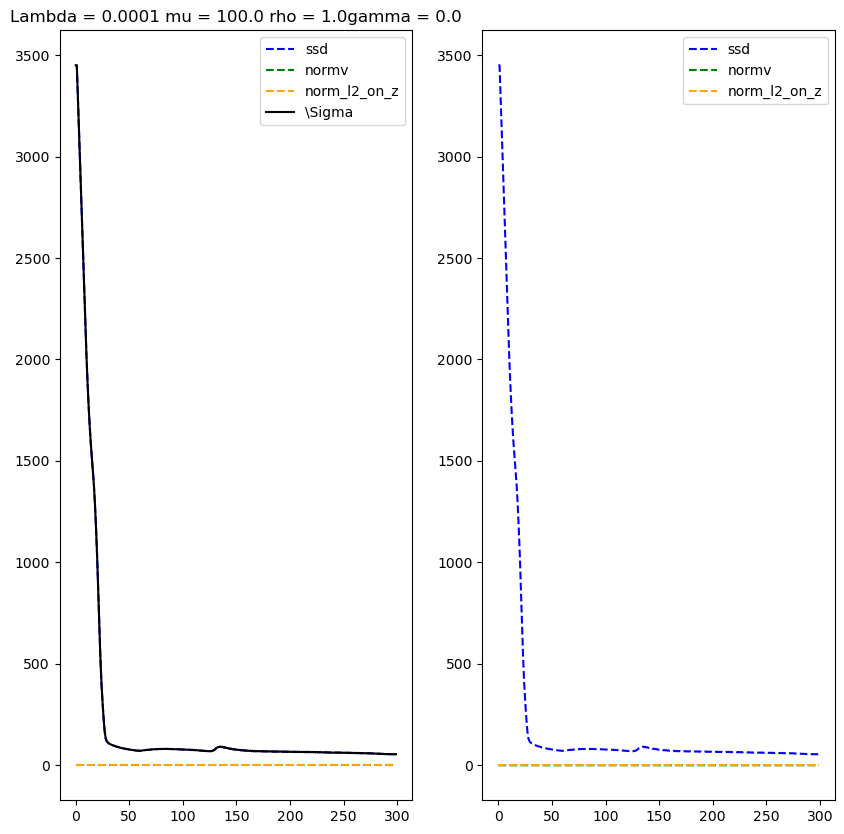

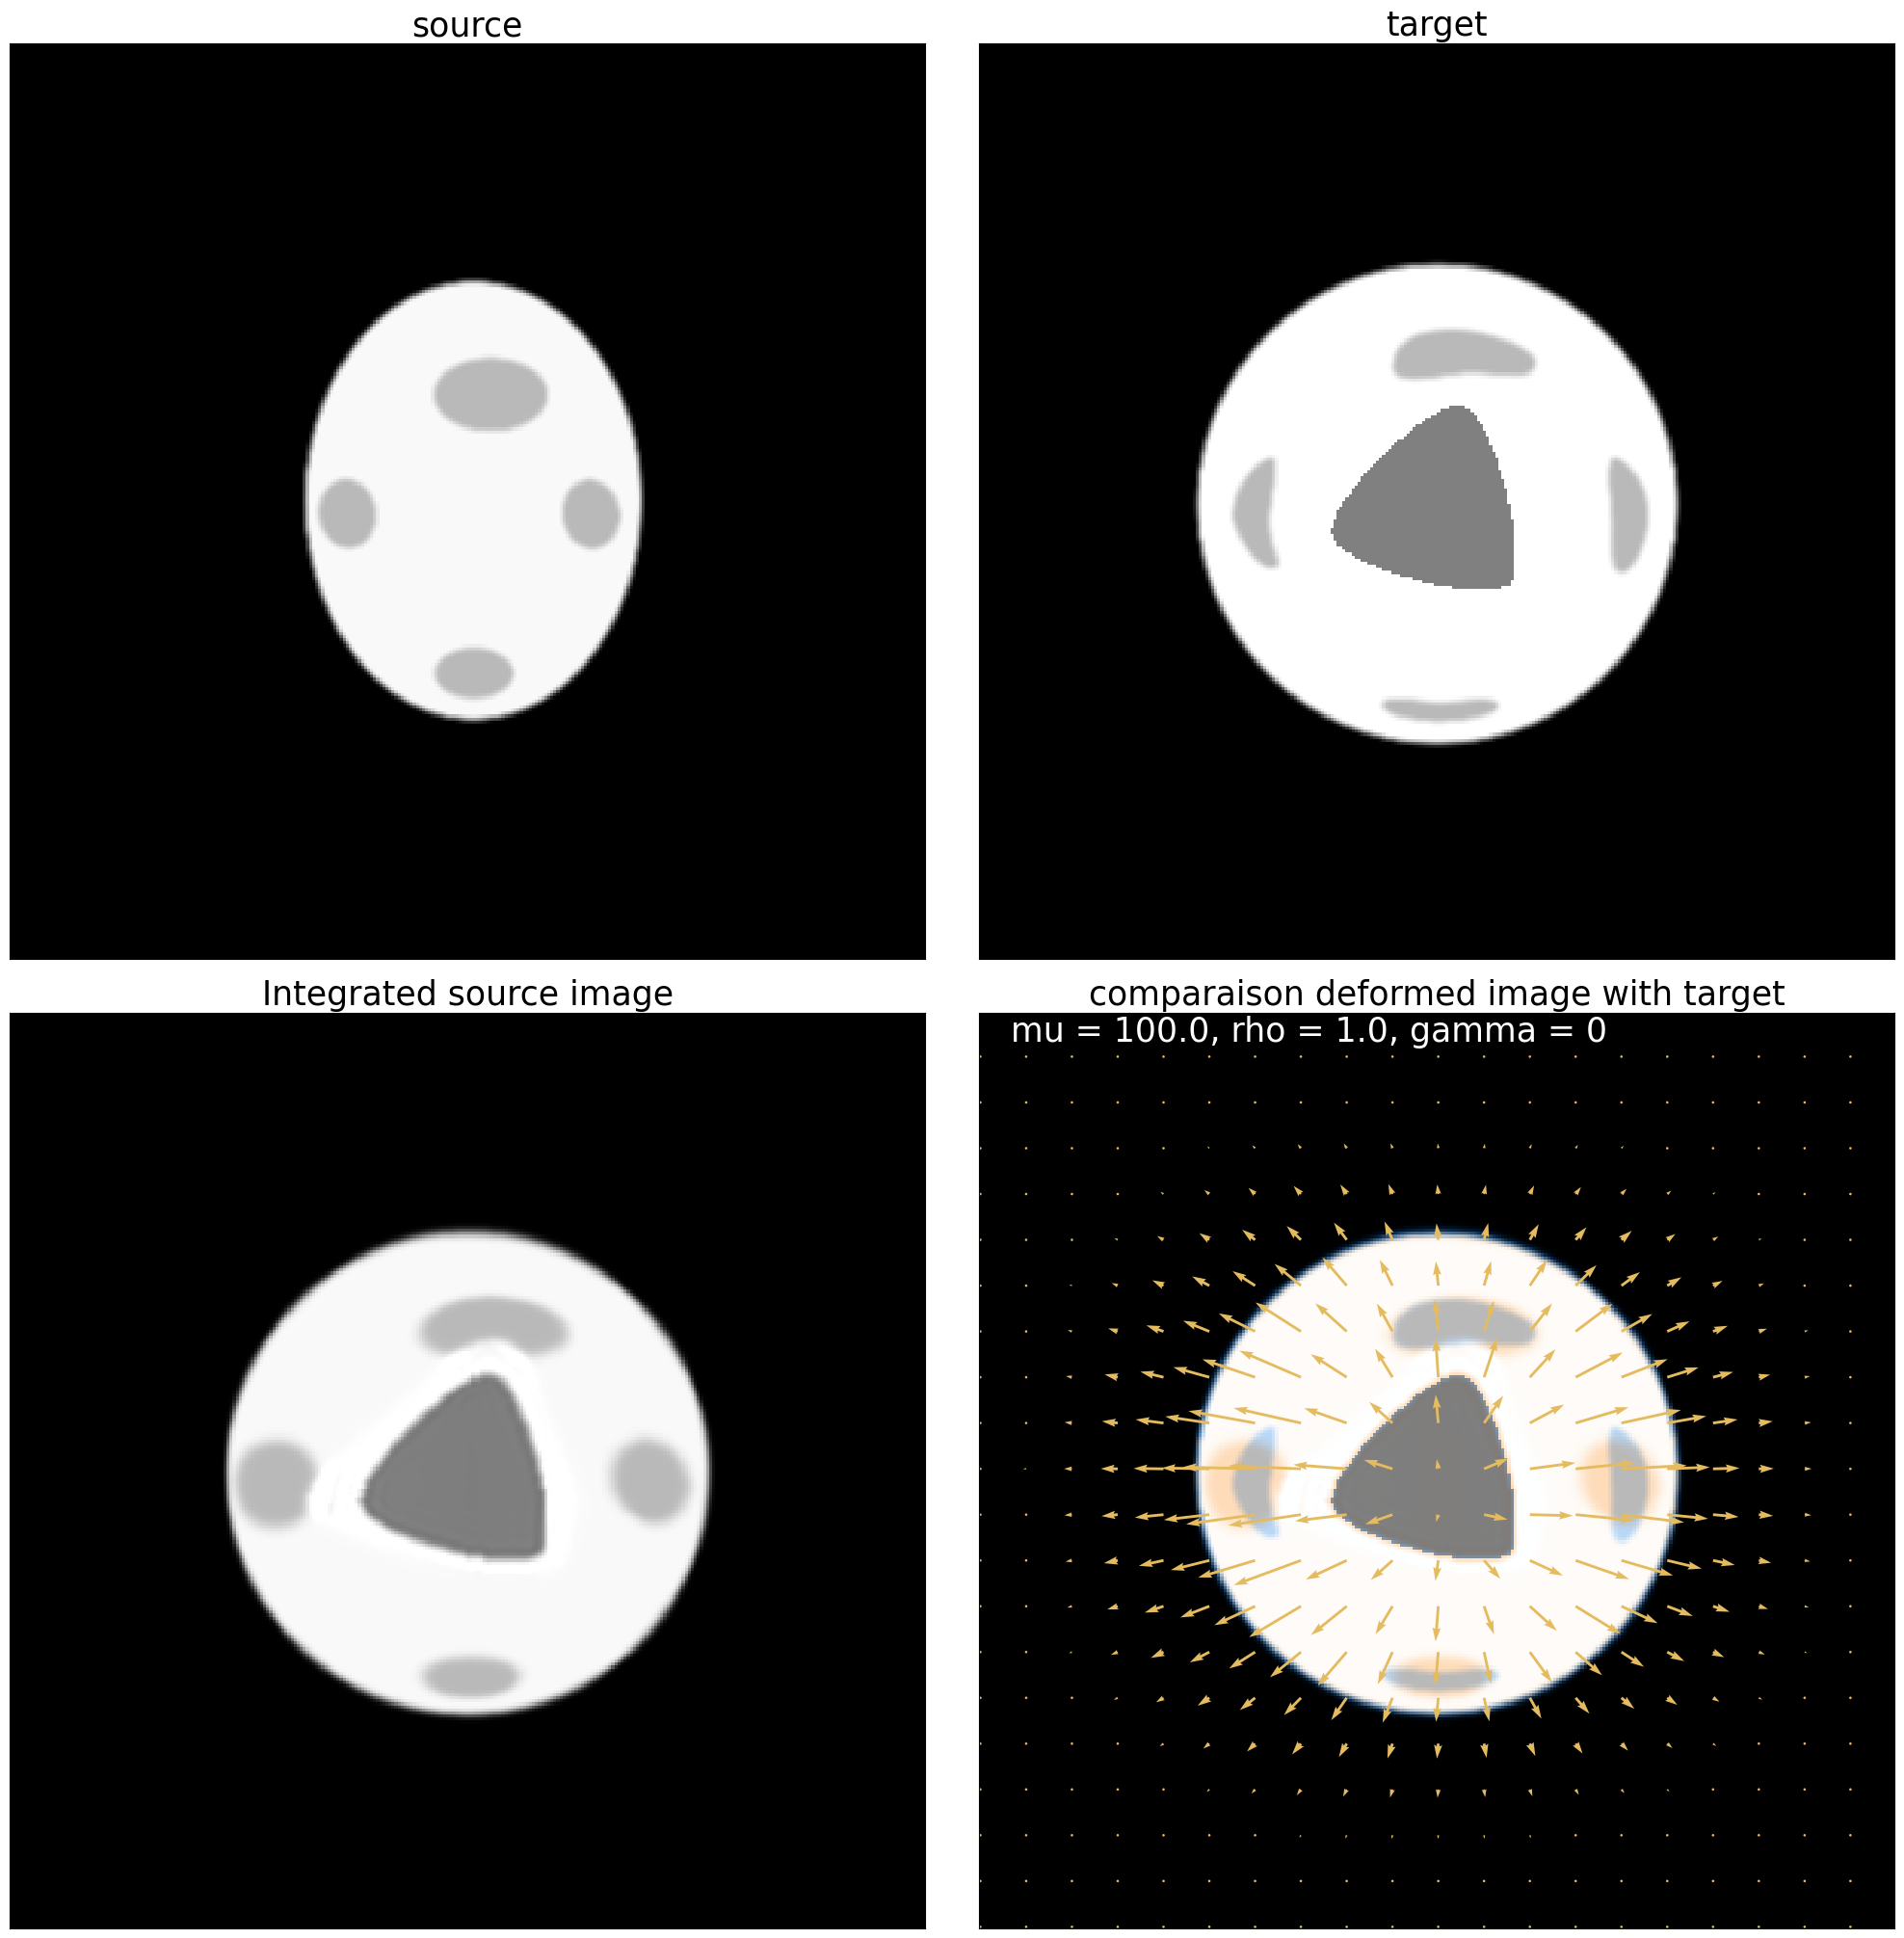

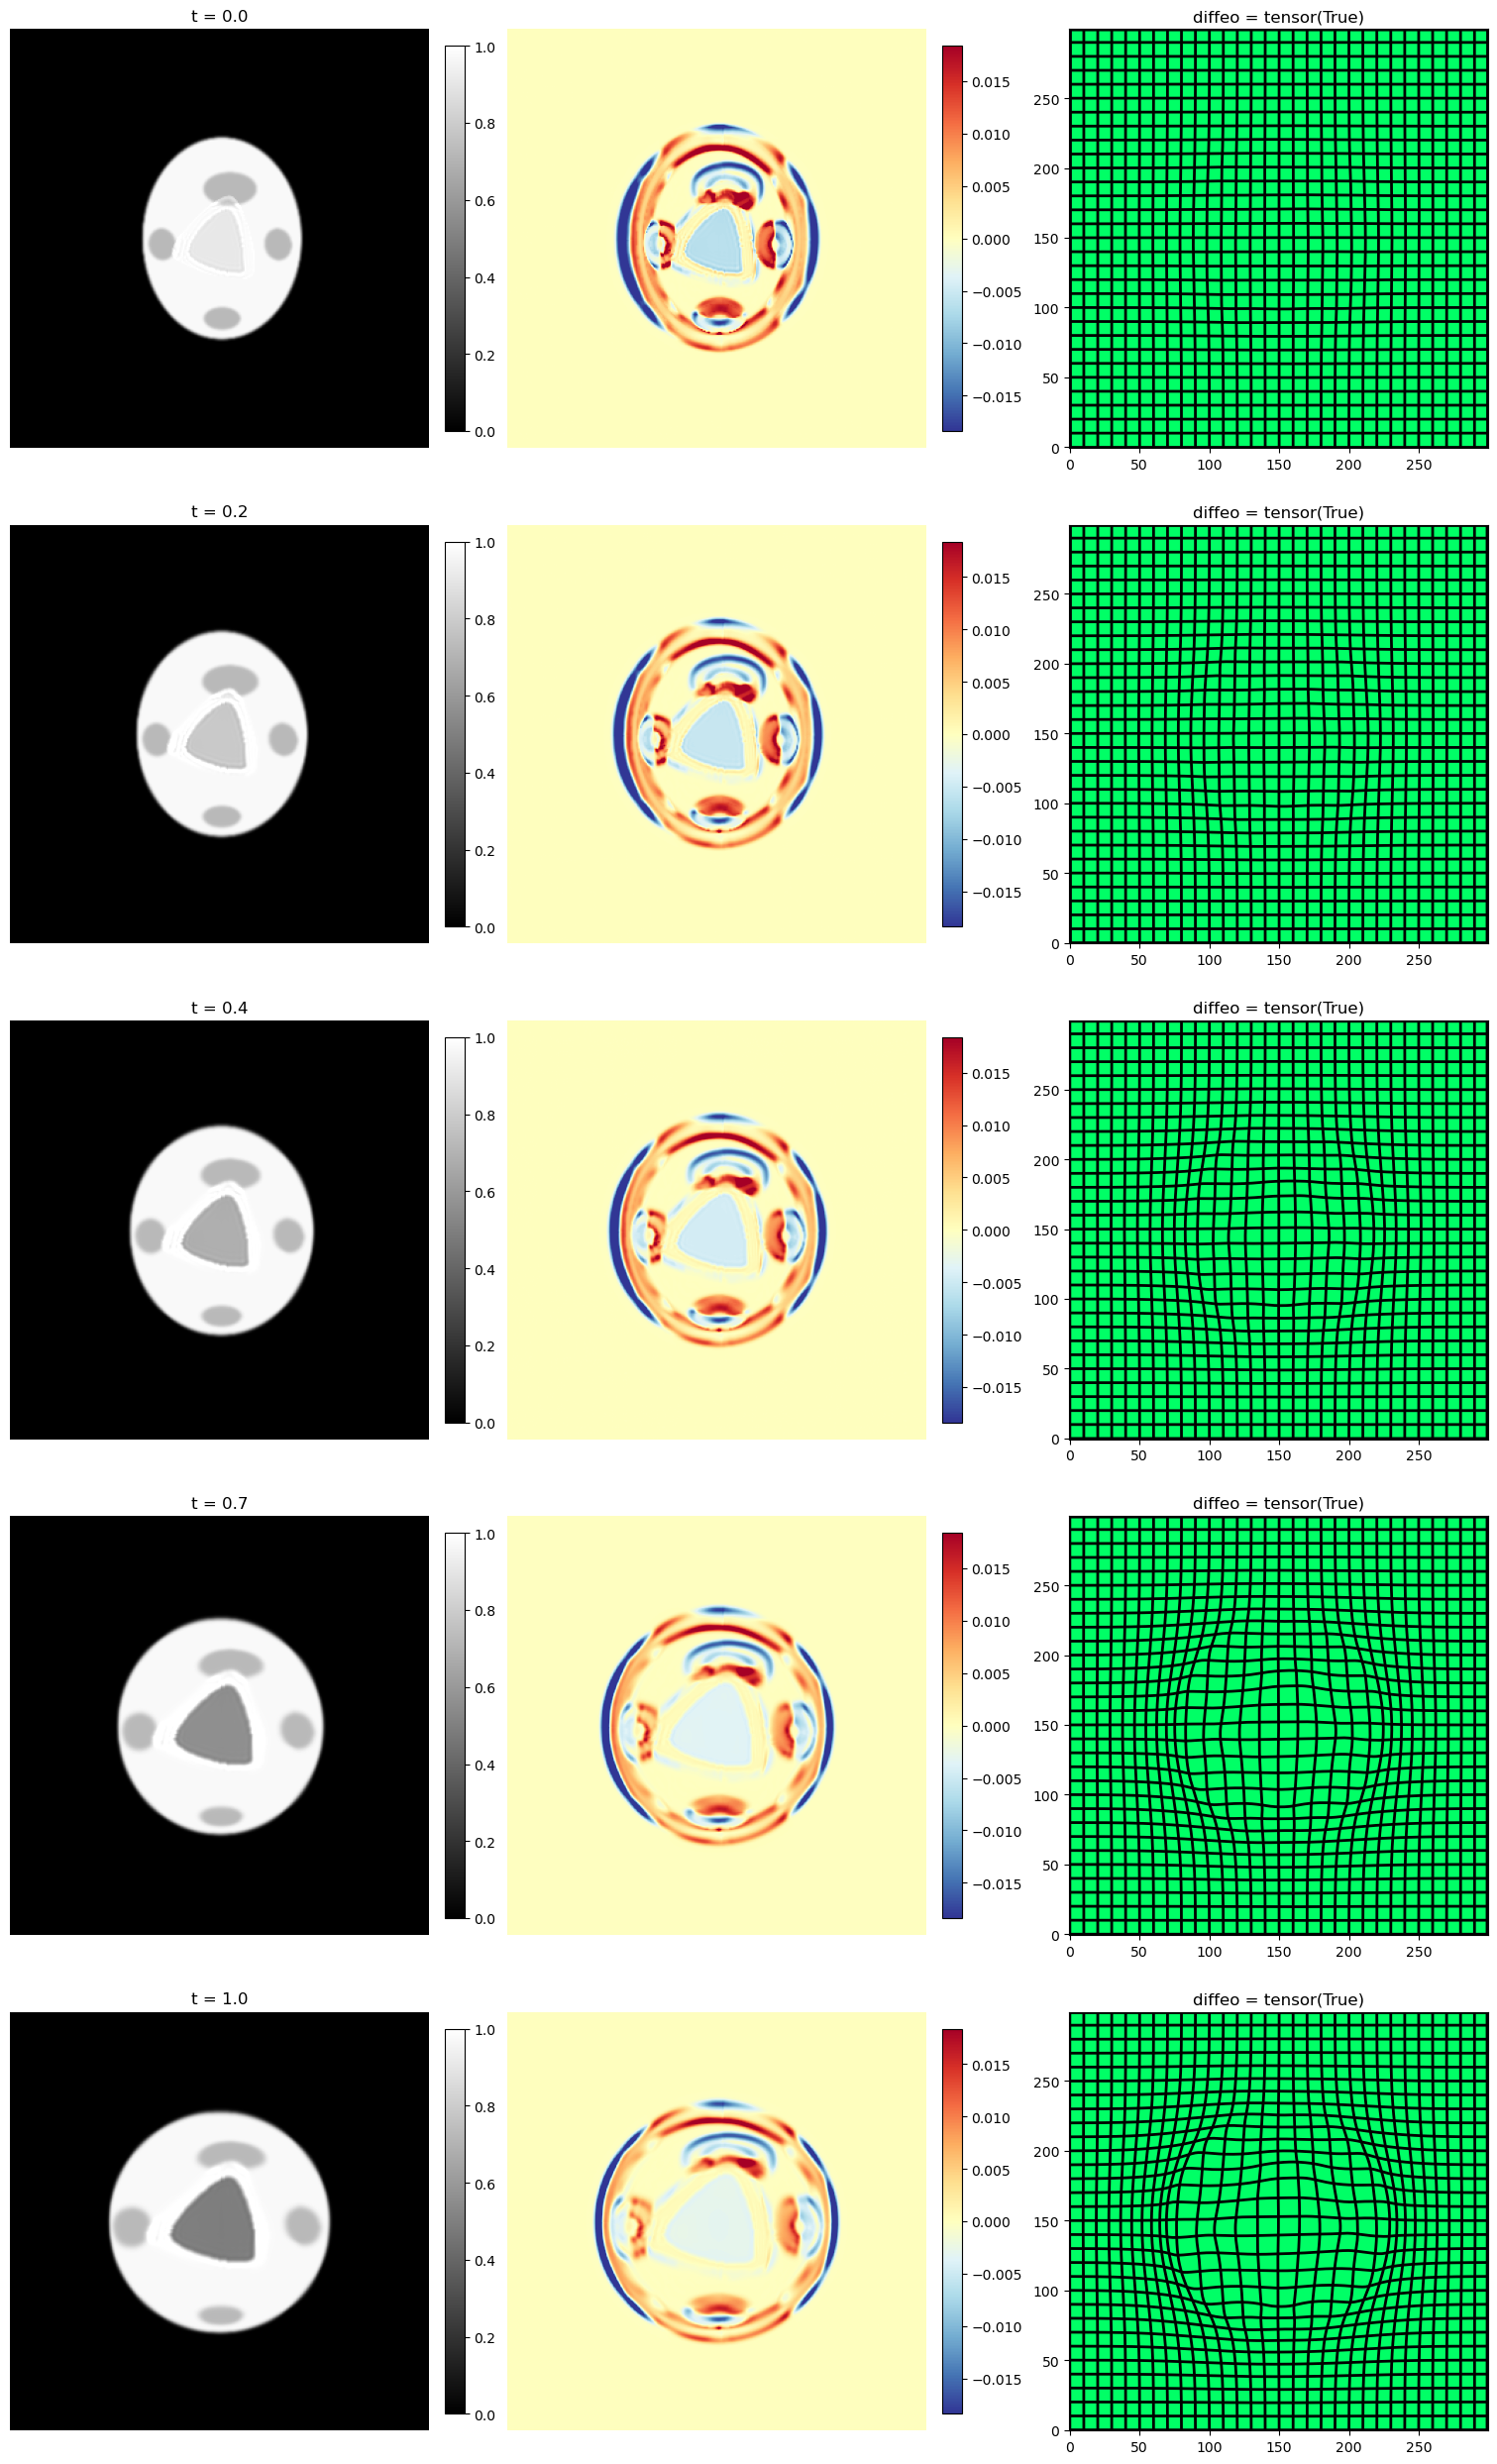

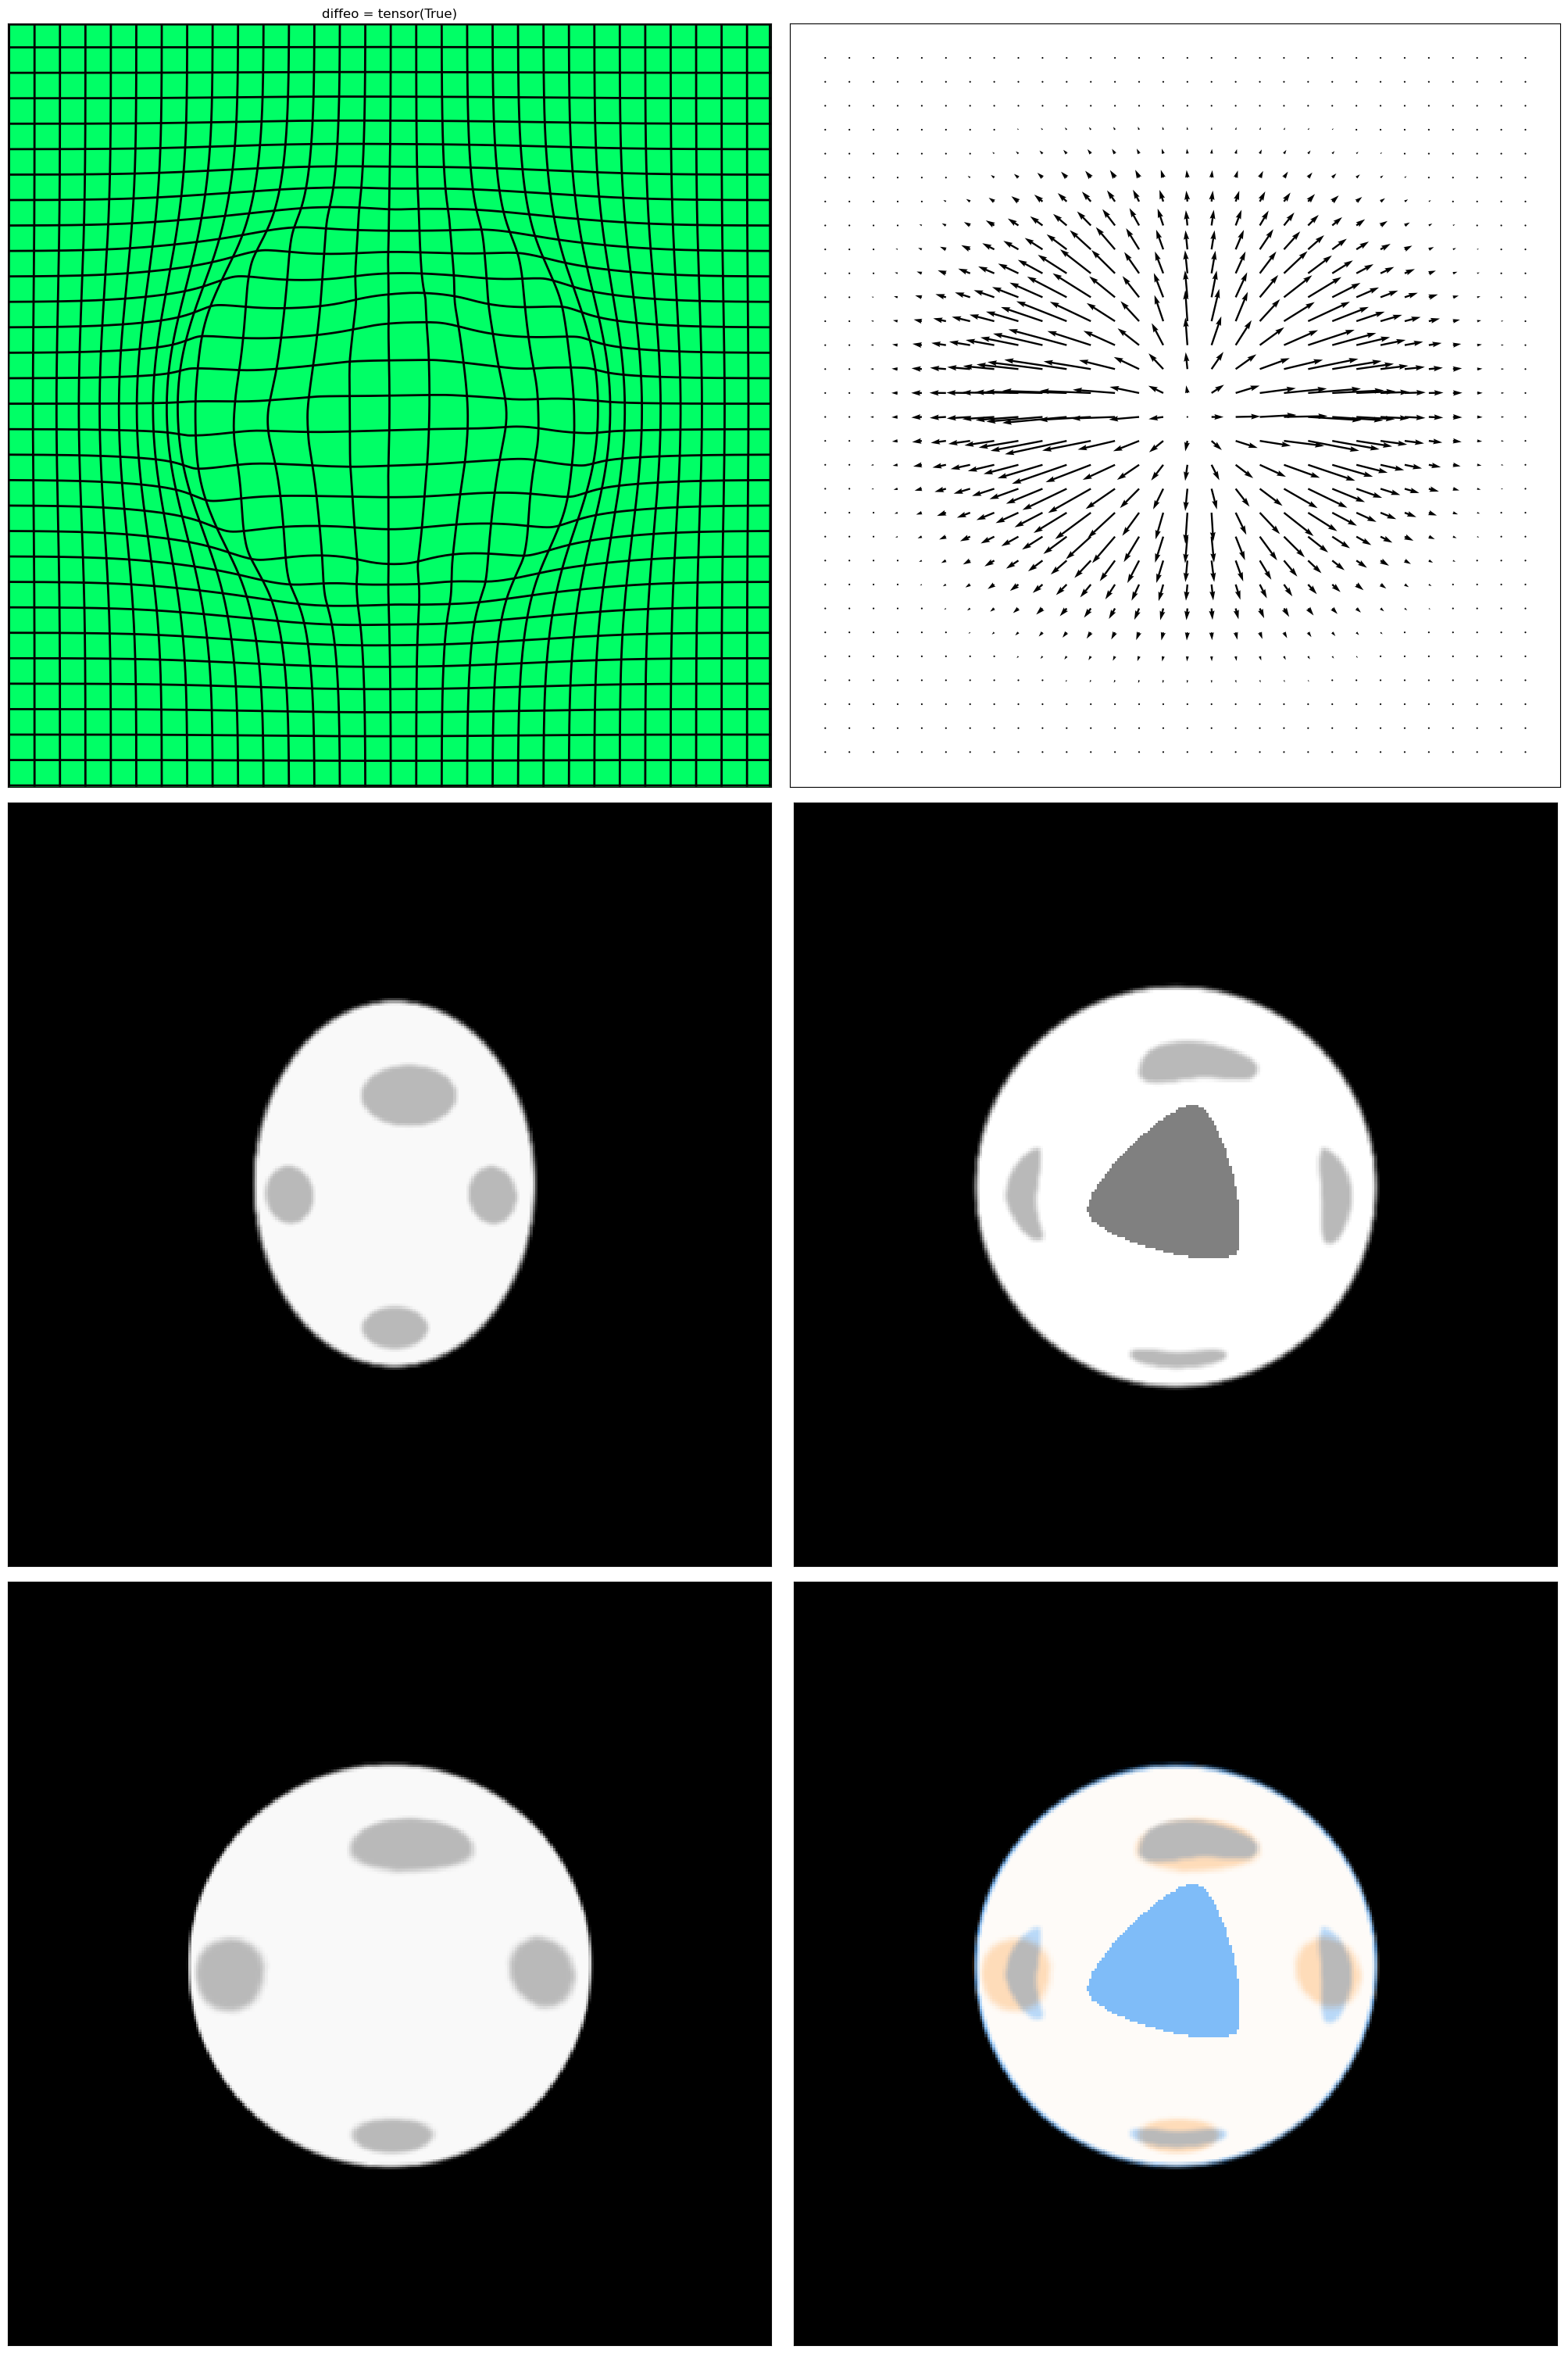

In [57]:
mr_wm.plot(False)
mr_wm.mp.plot()
mr_wm.plot_deform()

Annimation :
<img src="gifs/playExample_MetaMask_wb.gif" width="500" align="center">

## 2.b./ Weighted Metamoprhosis with evolutive mask

To compute the mask we simply apply a LDDMM registration to the segmentation from a small ball at its center, prior the registration. It is quick and need little parameter adjustments. Namely the variance sigma of the RKHS in order to get a mask more or less precise, and the number of integration, that that have to be the same as the main WM integration.

sigma :  (5, 5)
sigma :  (10, 10)
sigma :  (15, 15)
Progress: [##########] 100.00% Done...  ,   14.51).
 (ssd :  ,   14.45).
Computation of forward done in  0:00:10s and 0.189cents  s

Computation of lddmm done in  0:00:10s and 0.191cents  s

Computation done in  0:00:10s and 0.191cents  s


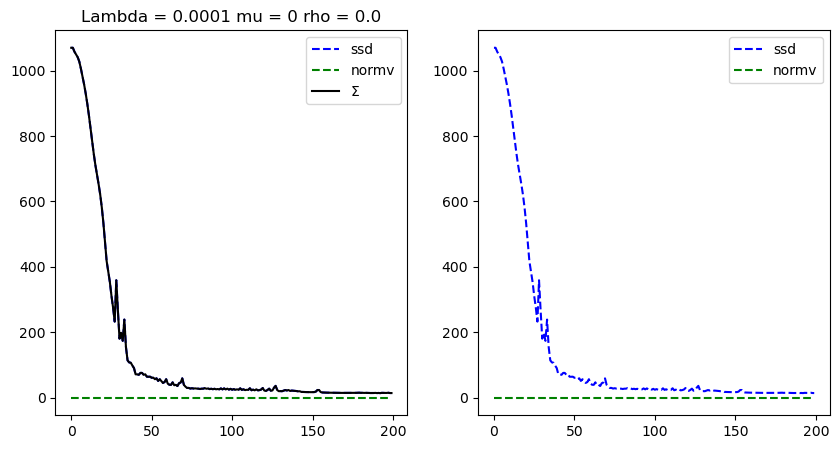

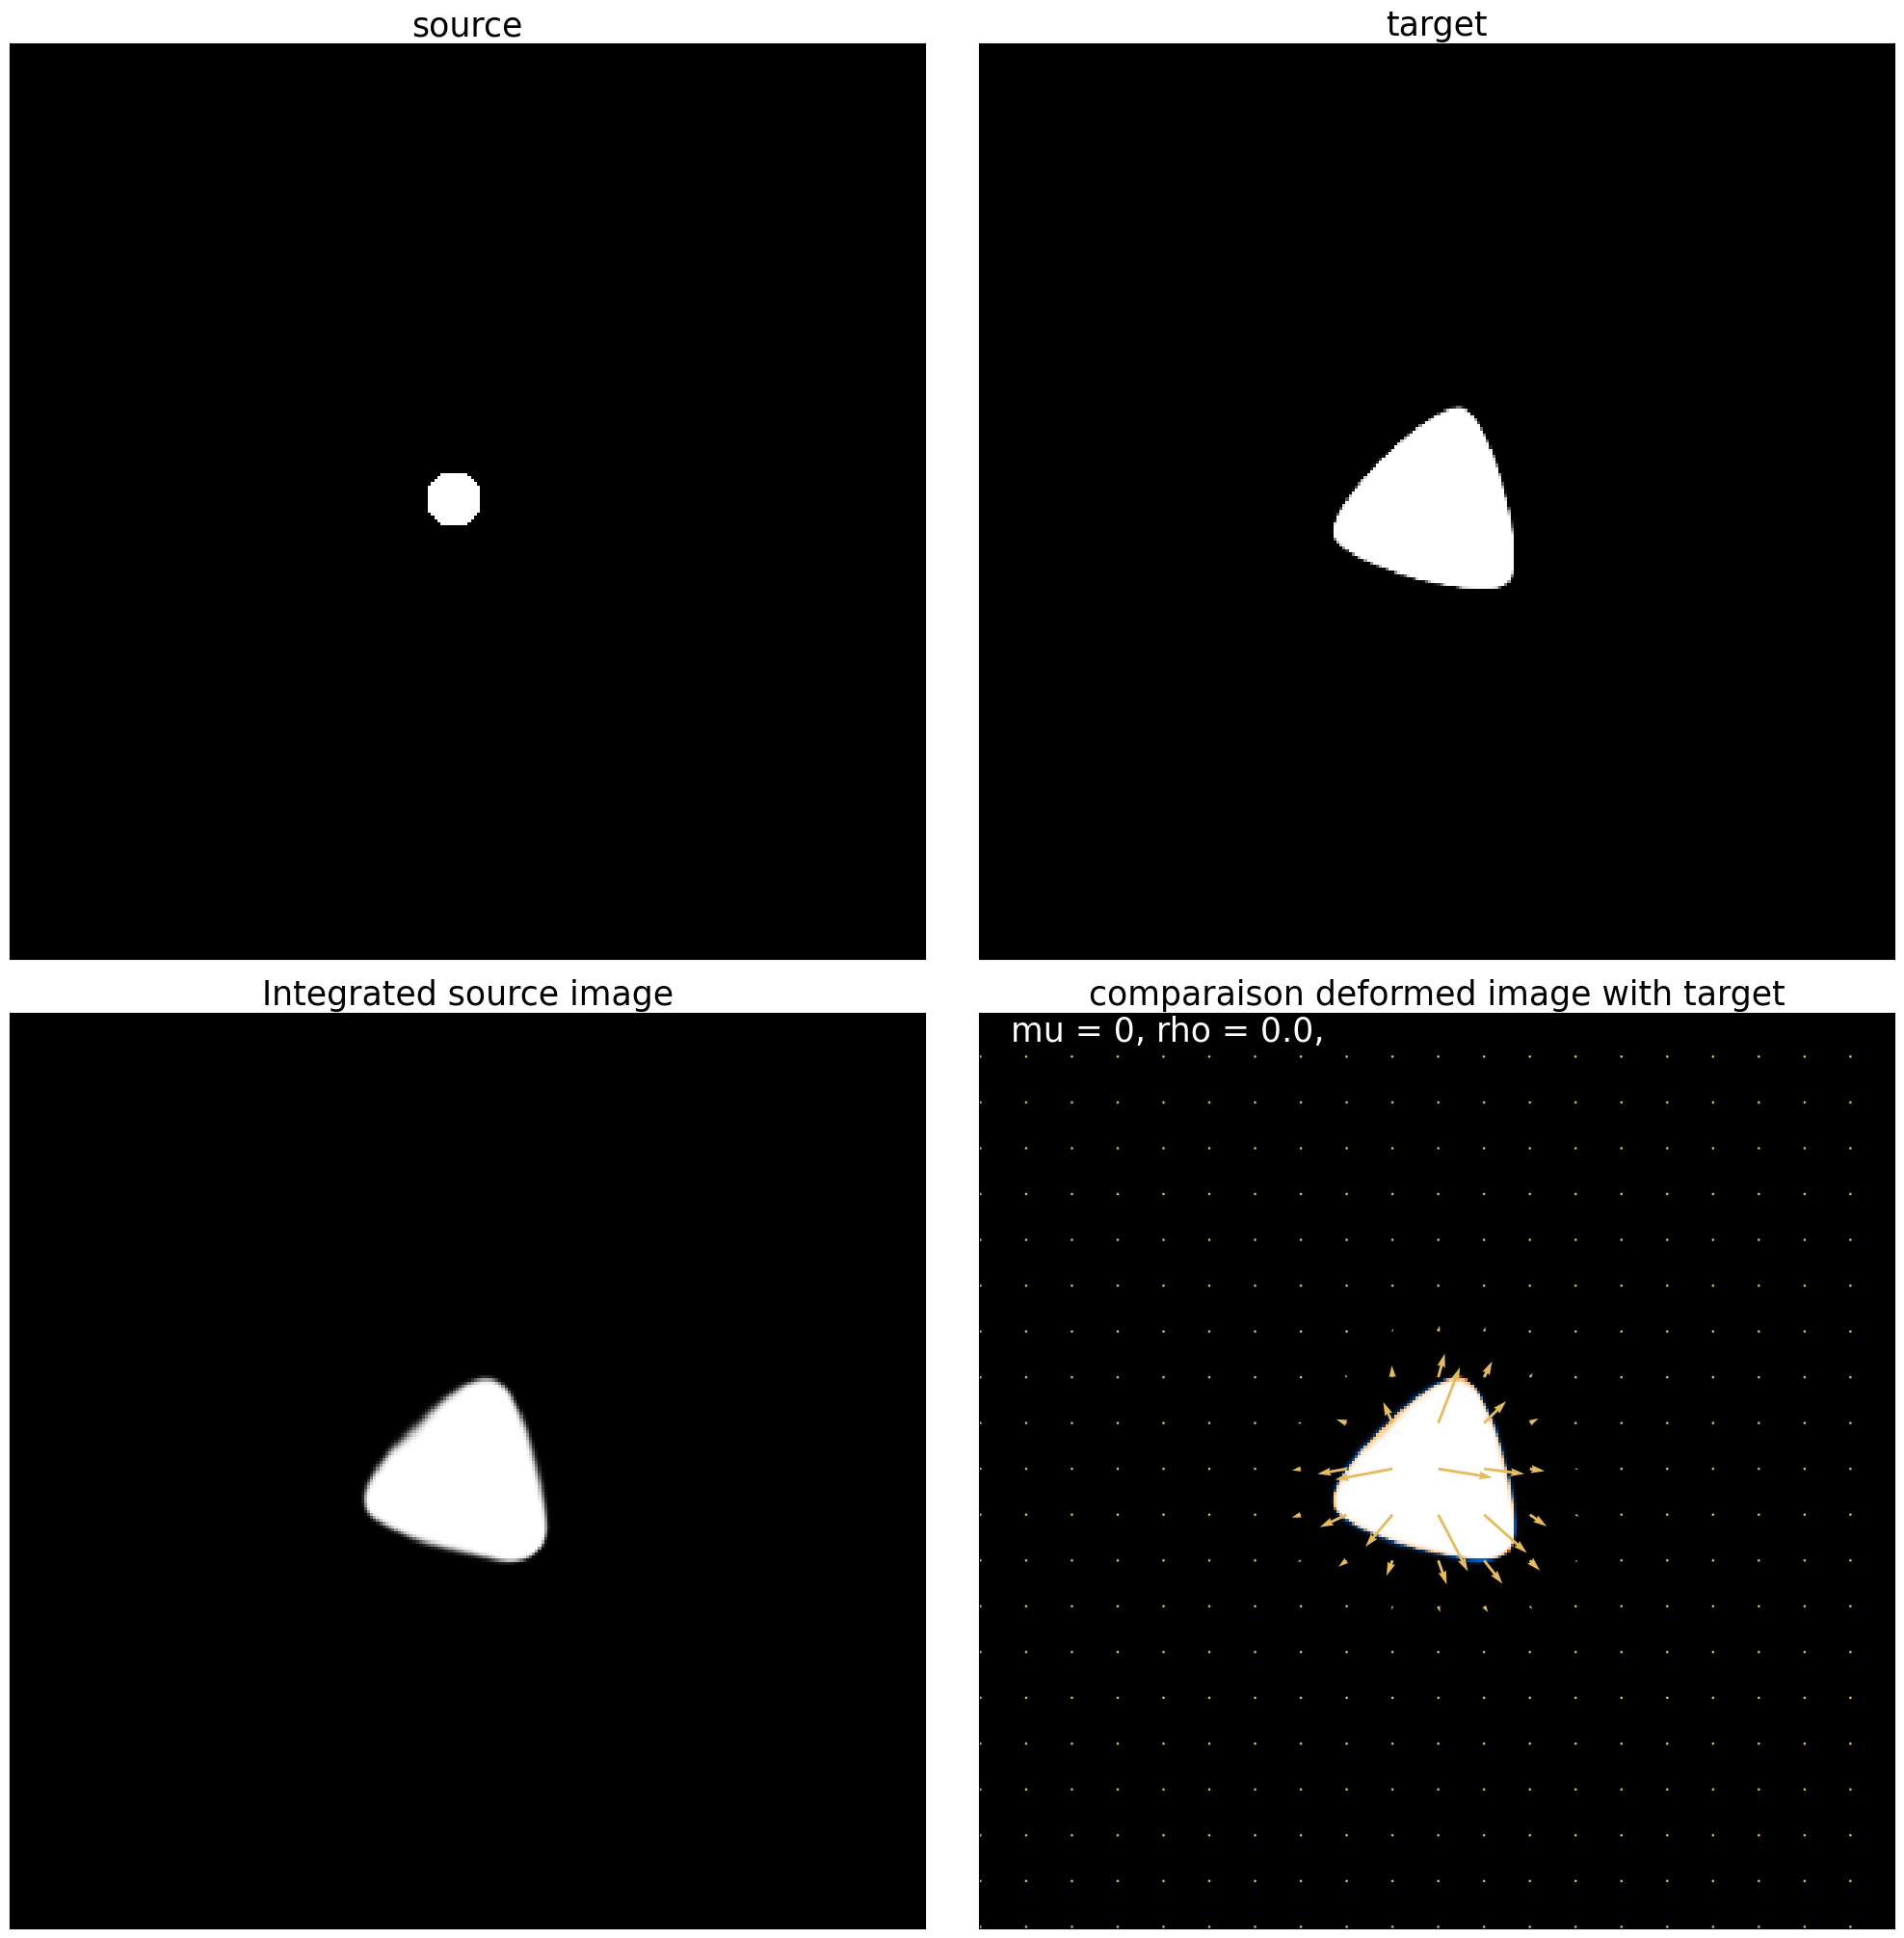

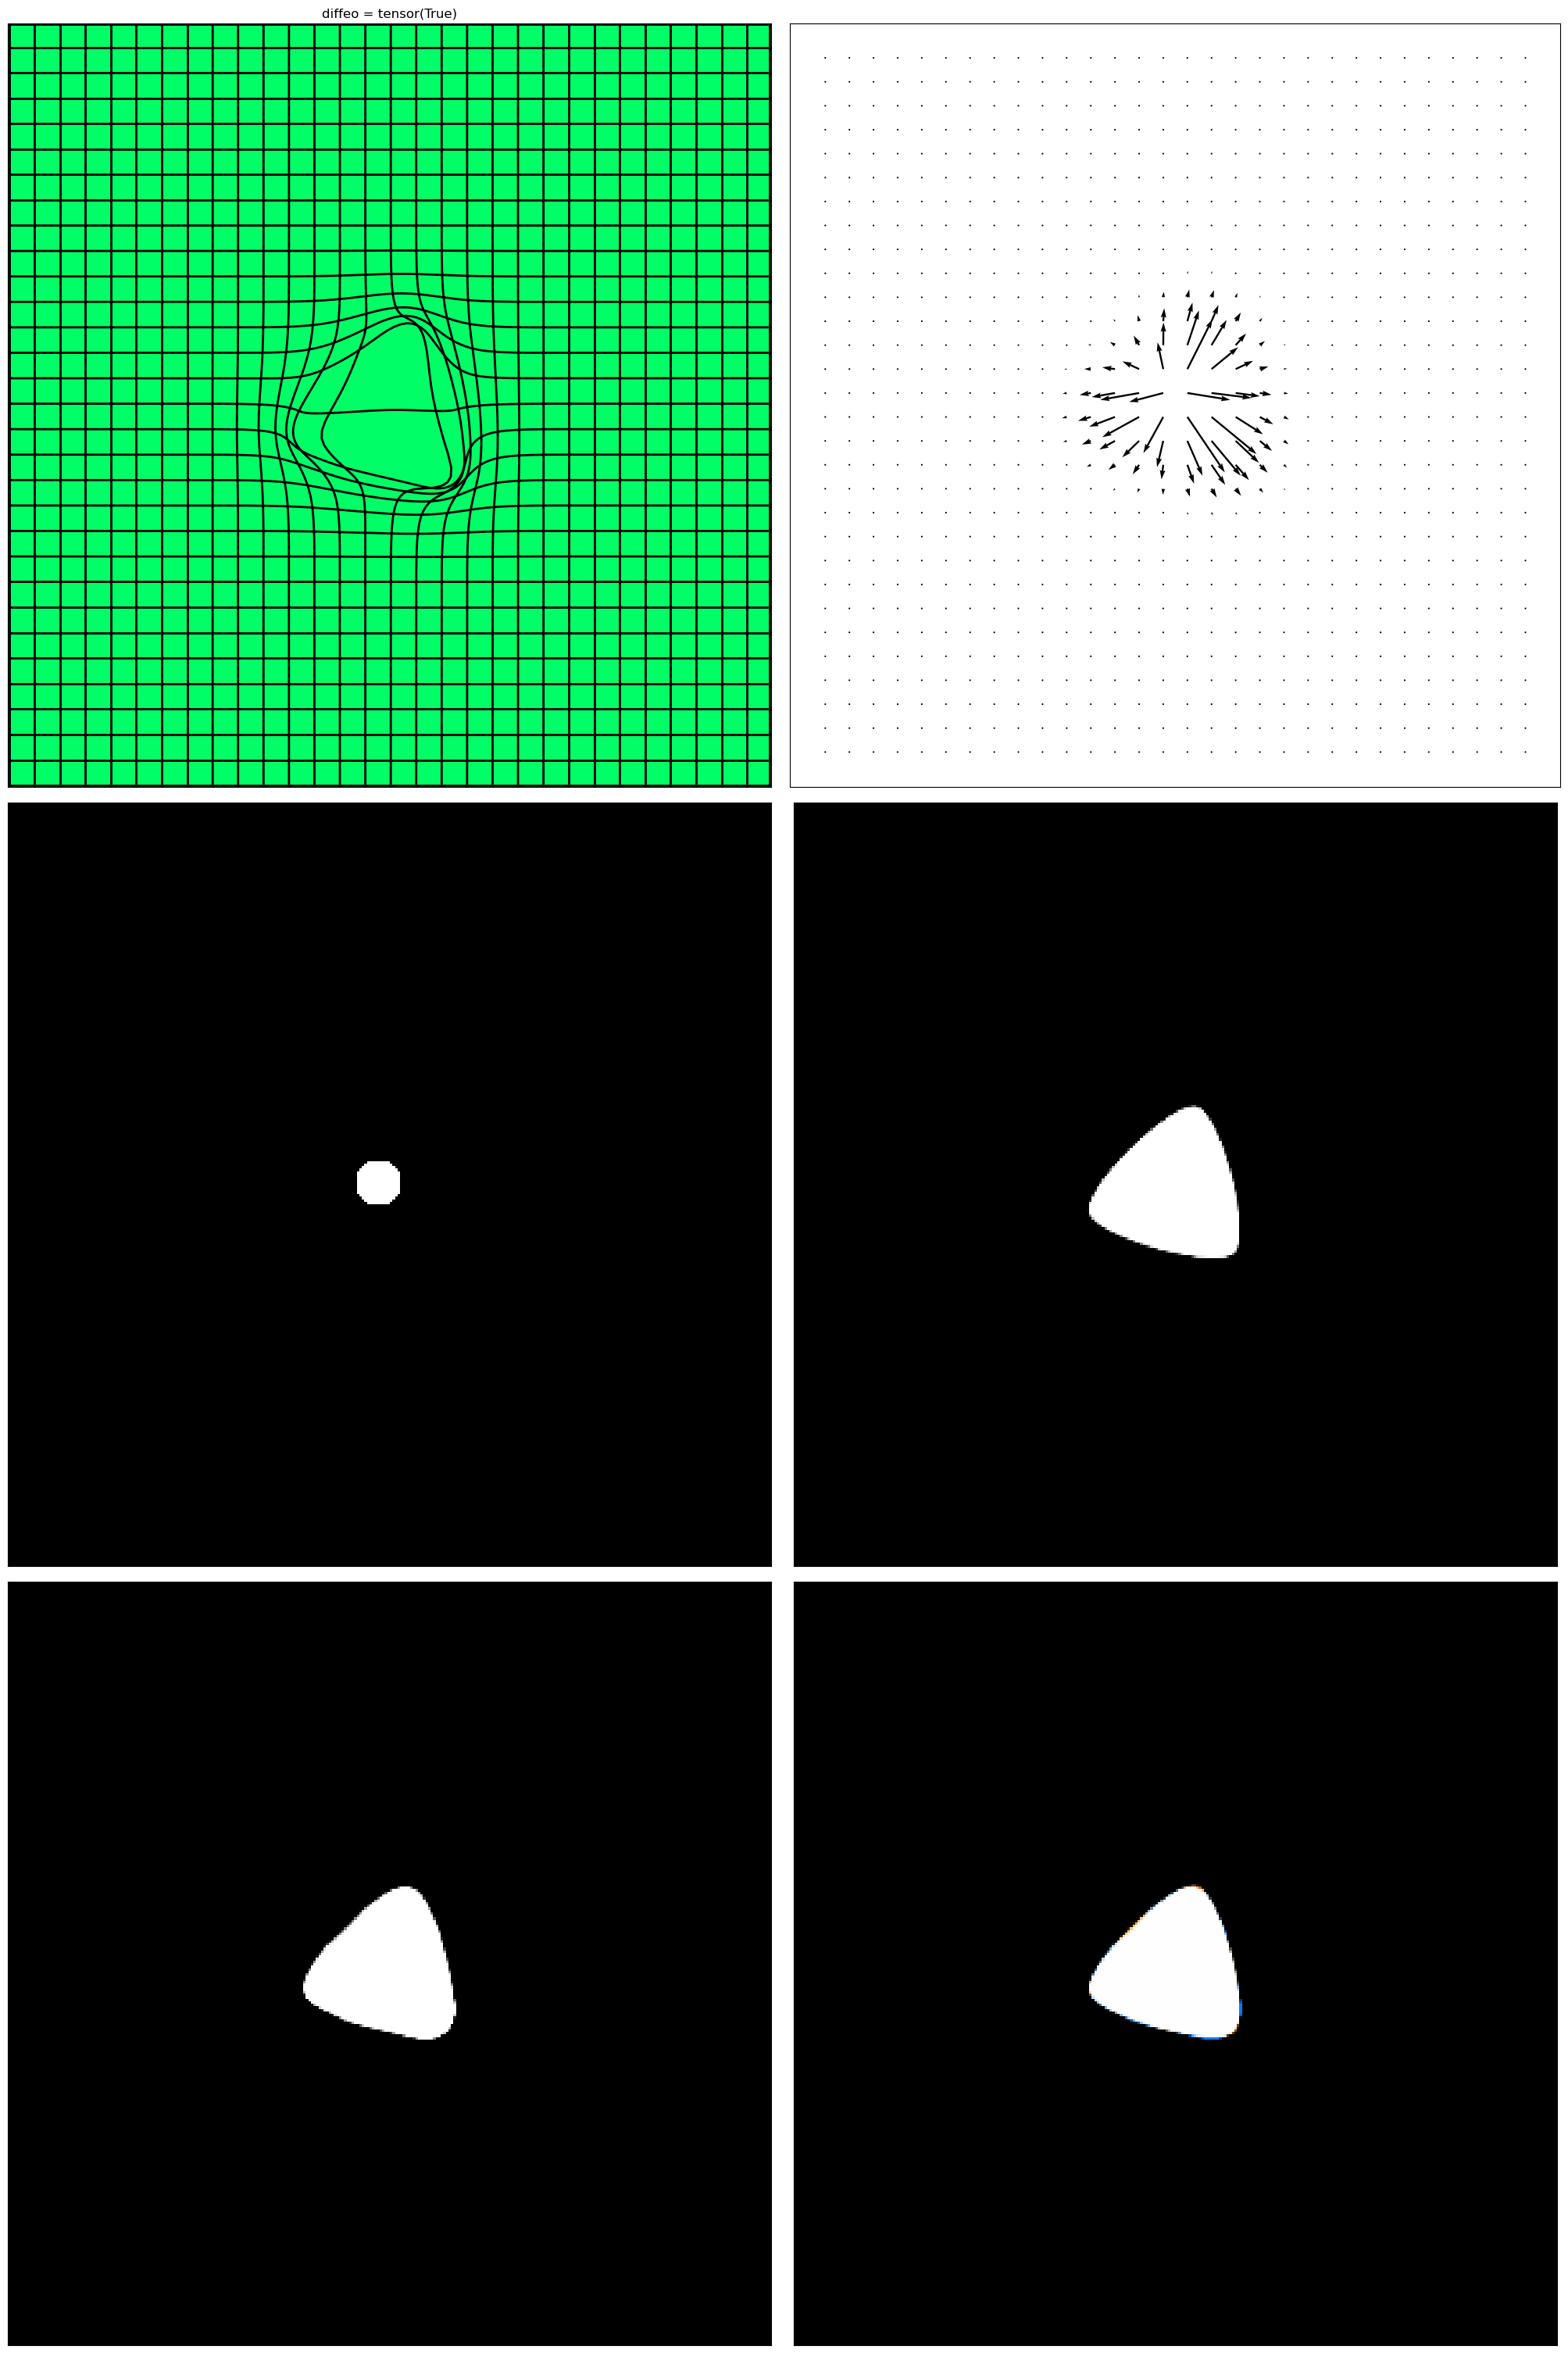

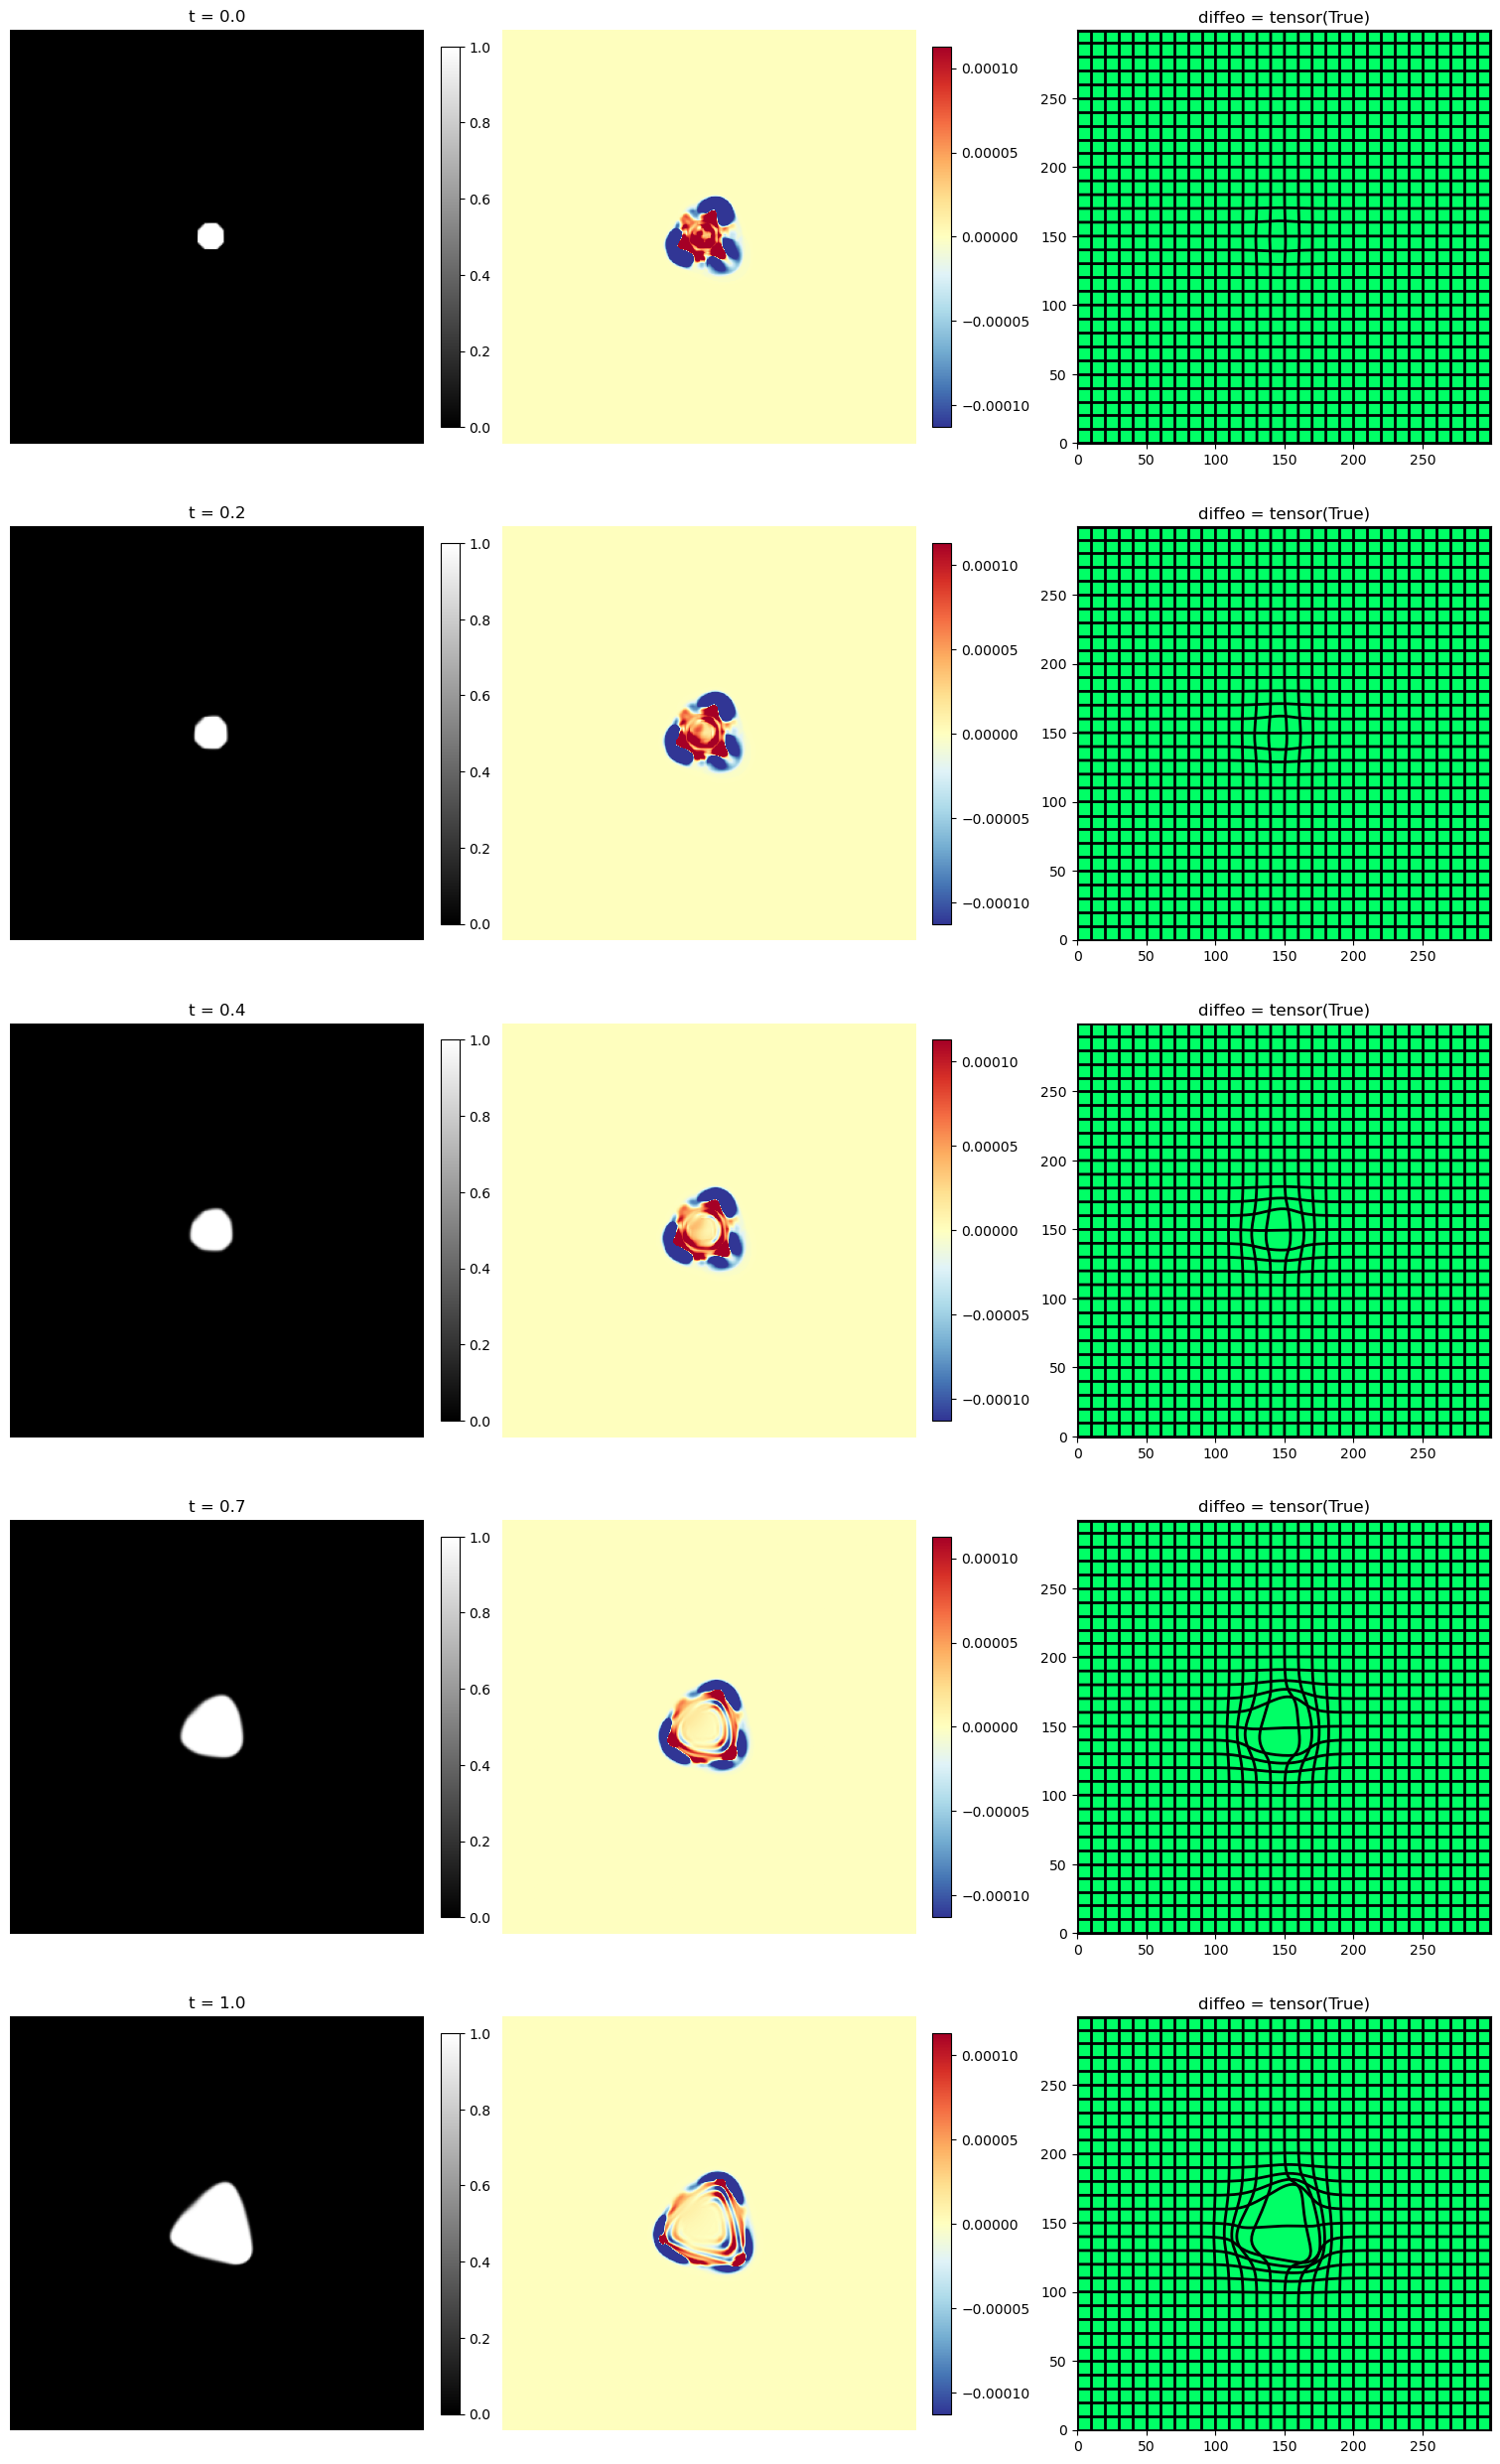

In [4]:


residuals = 0
start = time.time()
# sigma = [8,10]
mr = mt.lddmm(ini_ball,seg,residuals,sigma,.0001,
                    integration_steps=10,n_iter=200,grad_coef=1e-3,
                    safe_mode=False,
                  dx_convention='square')
end = time.time()
print("\nComputation done in ",format_time(end - start)," s")
mr.plot()
mr.plot_deform()
mr.mp.plot()
mask = mr.mp.image_stock  # Saving the succession of images.


The mask will be the successives images on the left column. 
We use the same parameters than the experiment with constant mask.

sigma :  (1, 1)
sigma :  (5, 5)
sigma :  (10, 10)
sigma :  (30, 30)
None
Weighted
not oriented
Progress: [##########] 100.00% Done...  ,   63.06).
 (ssd :  ,   65.17).
Computation of forward done in  0:00:18s and 0.034cents  s

Computation of weighted_metamorphosis done in  0:00:18s and 0.047cents  s


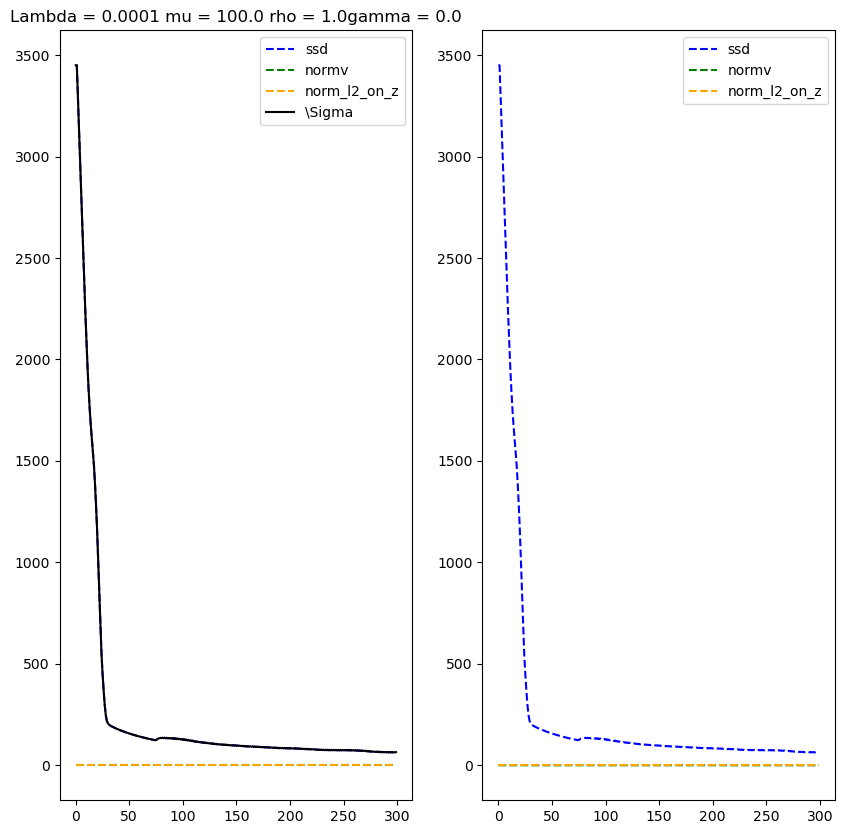

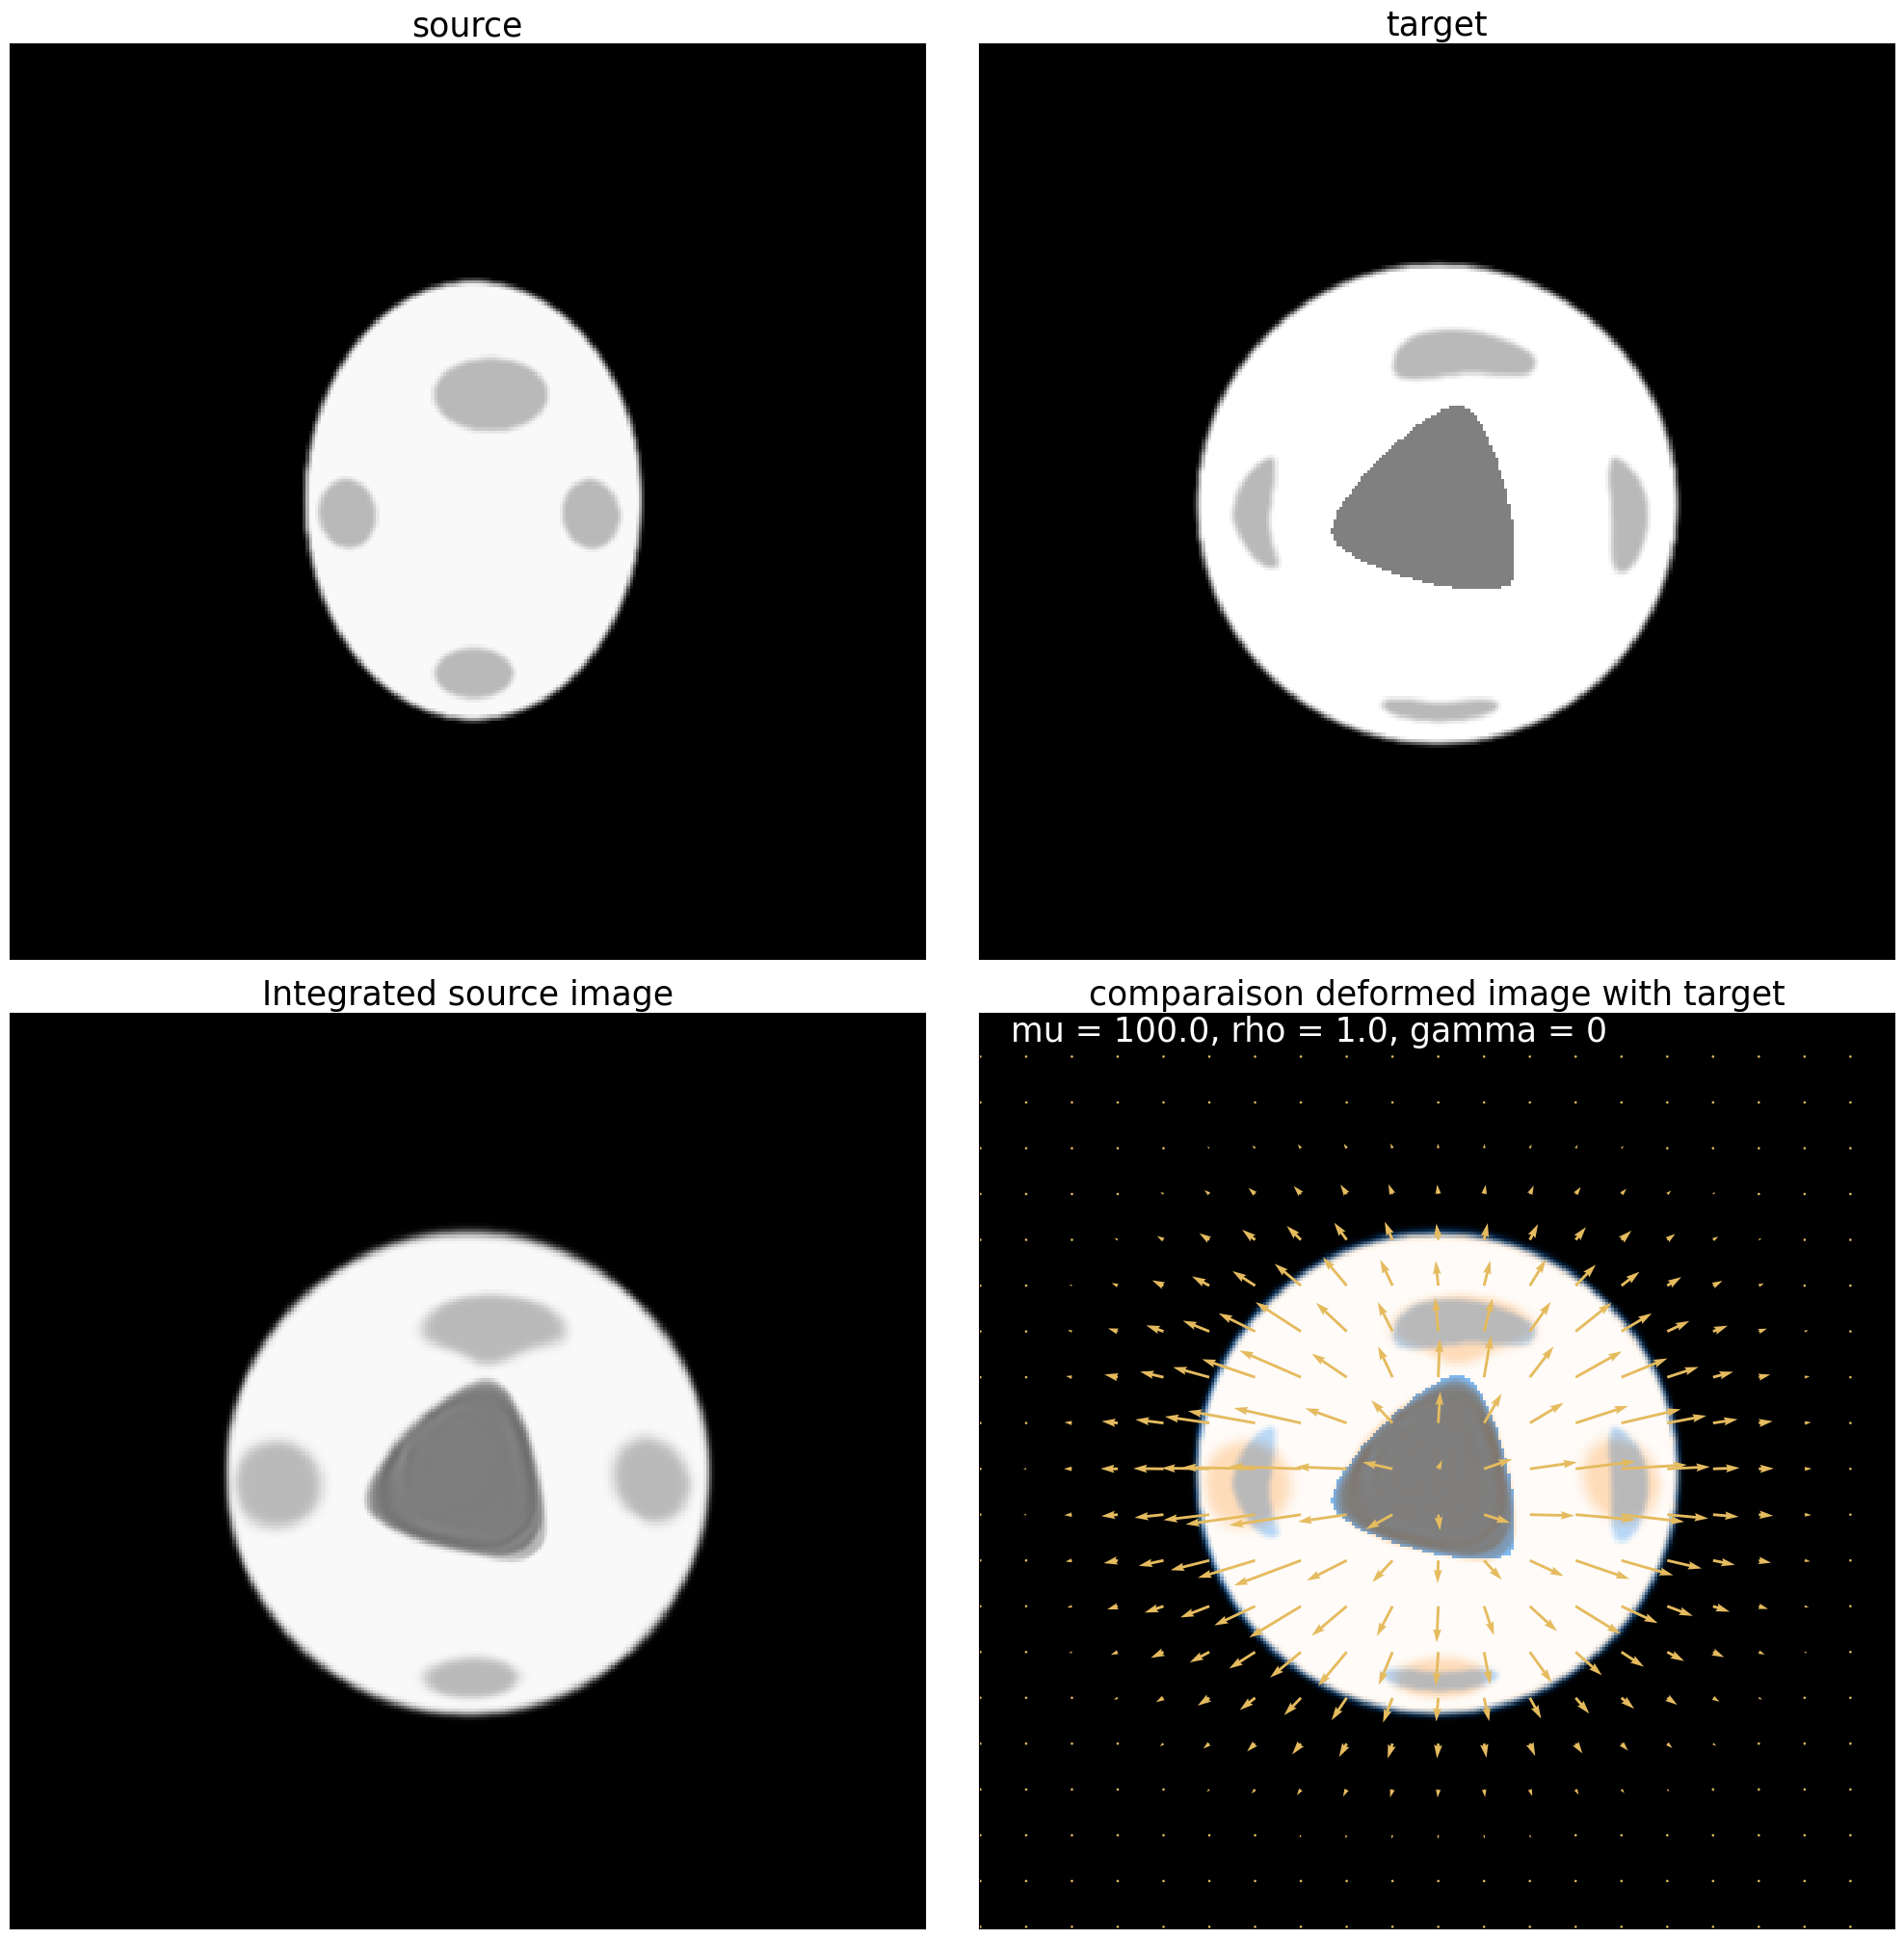

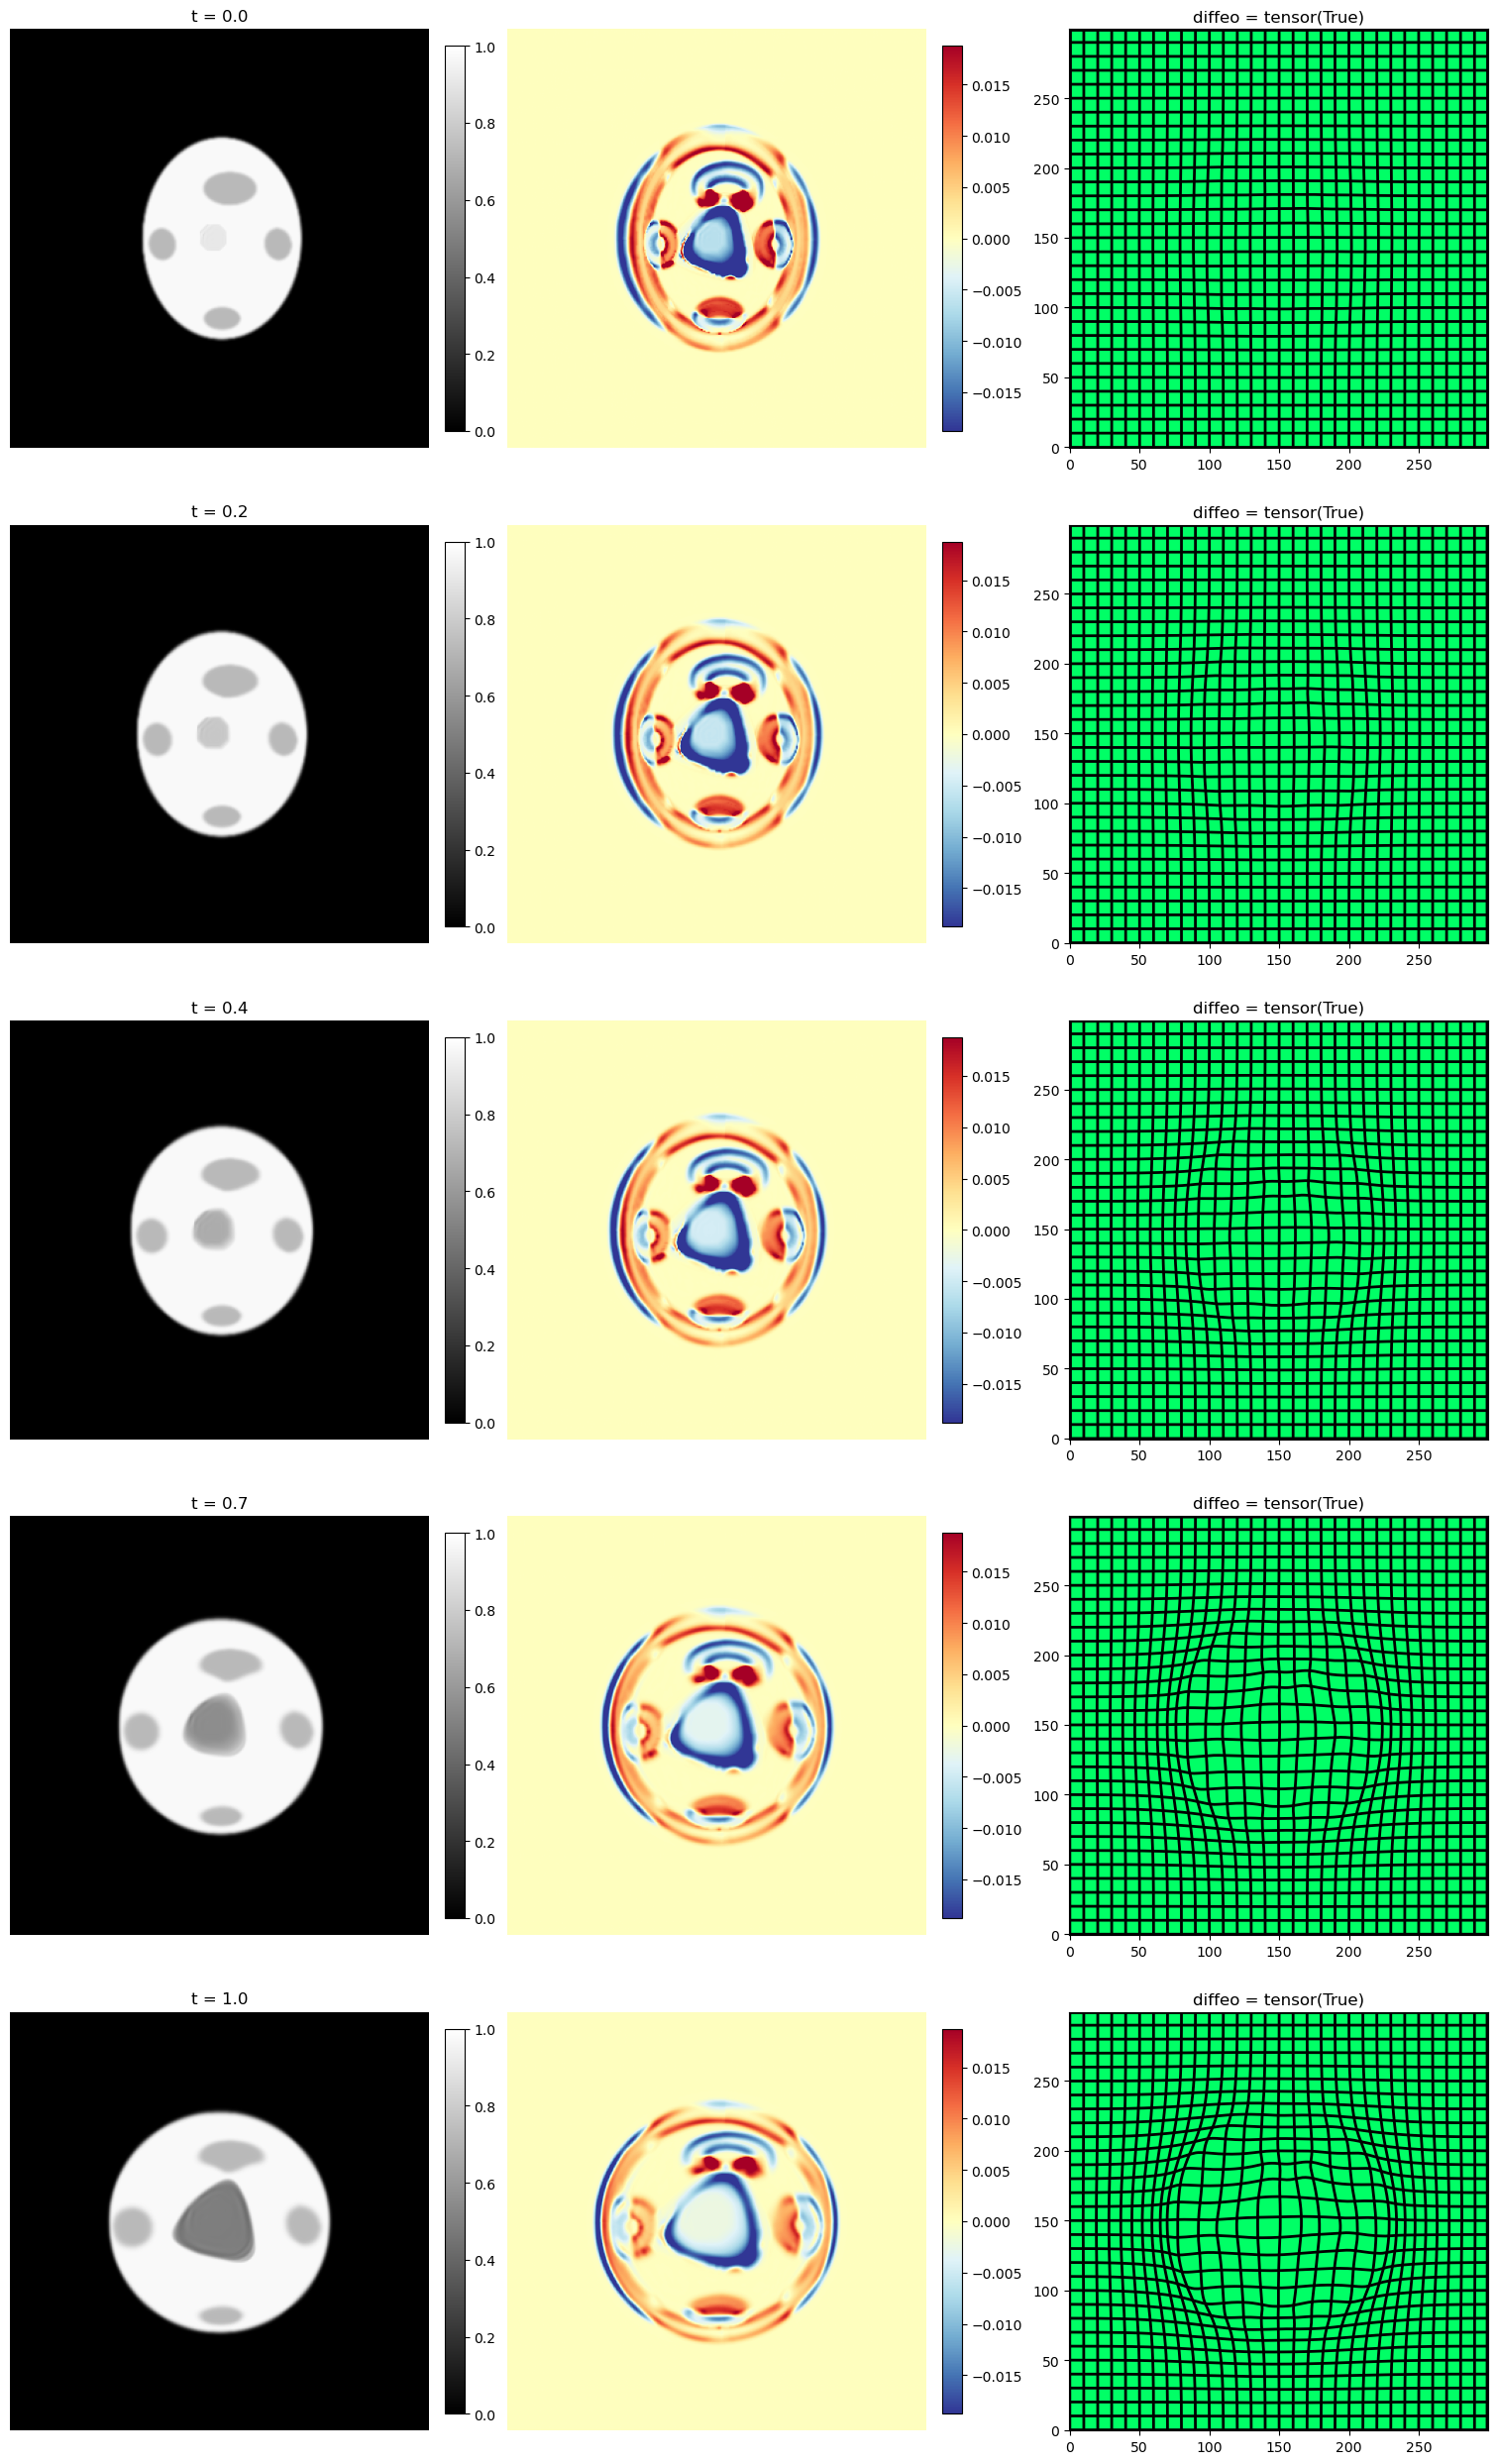

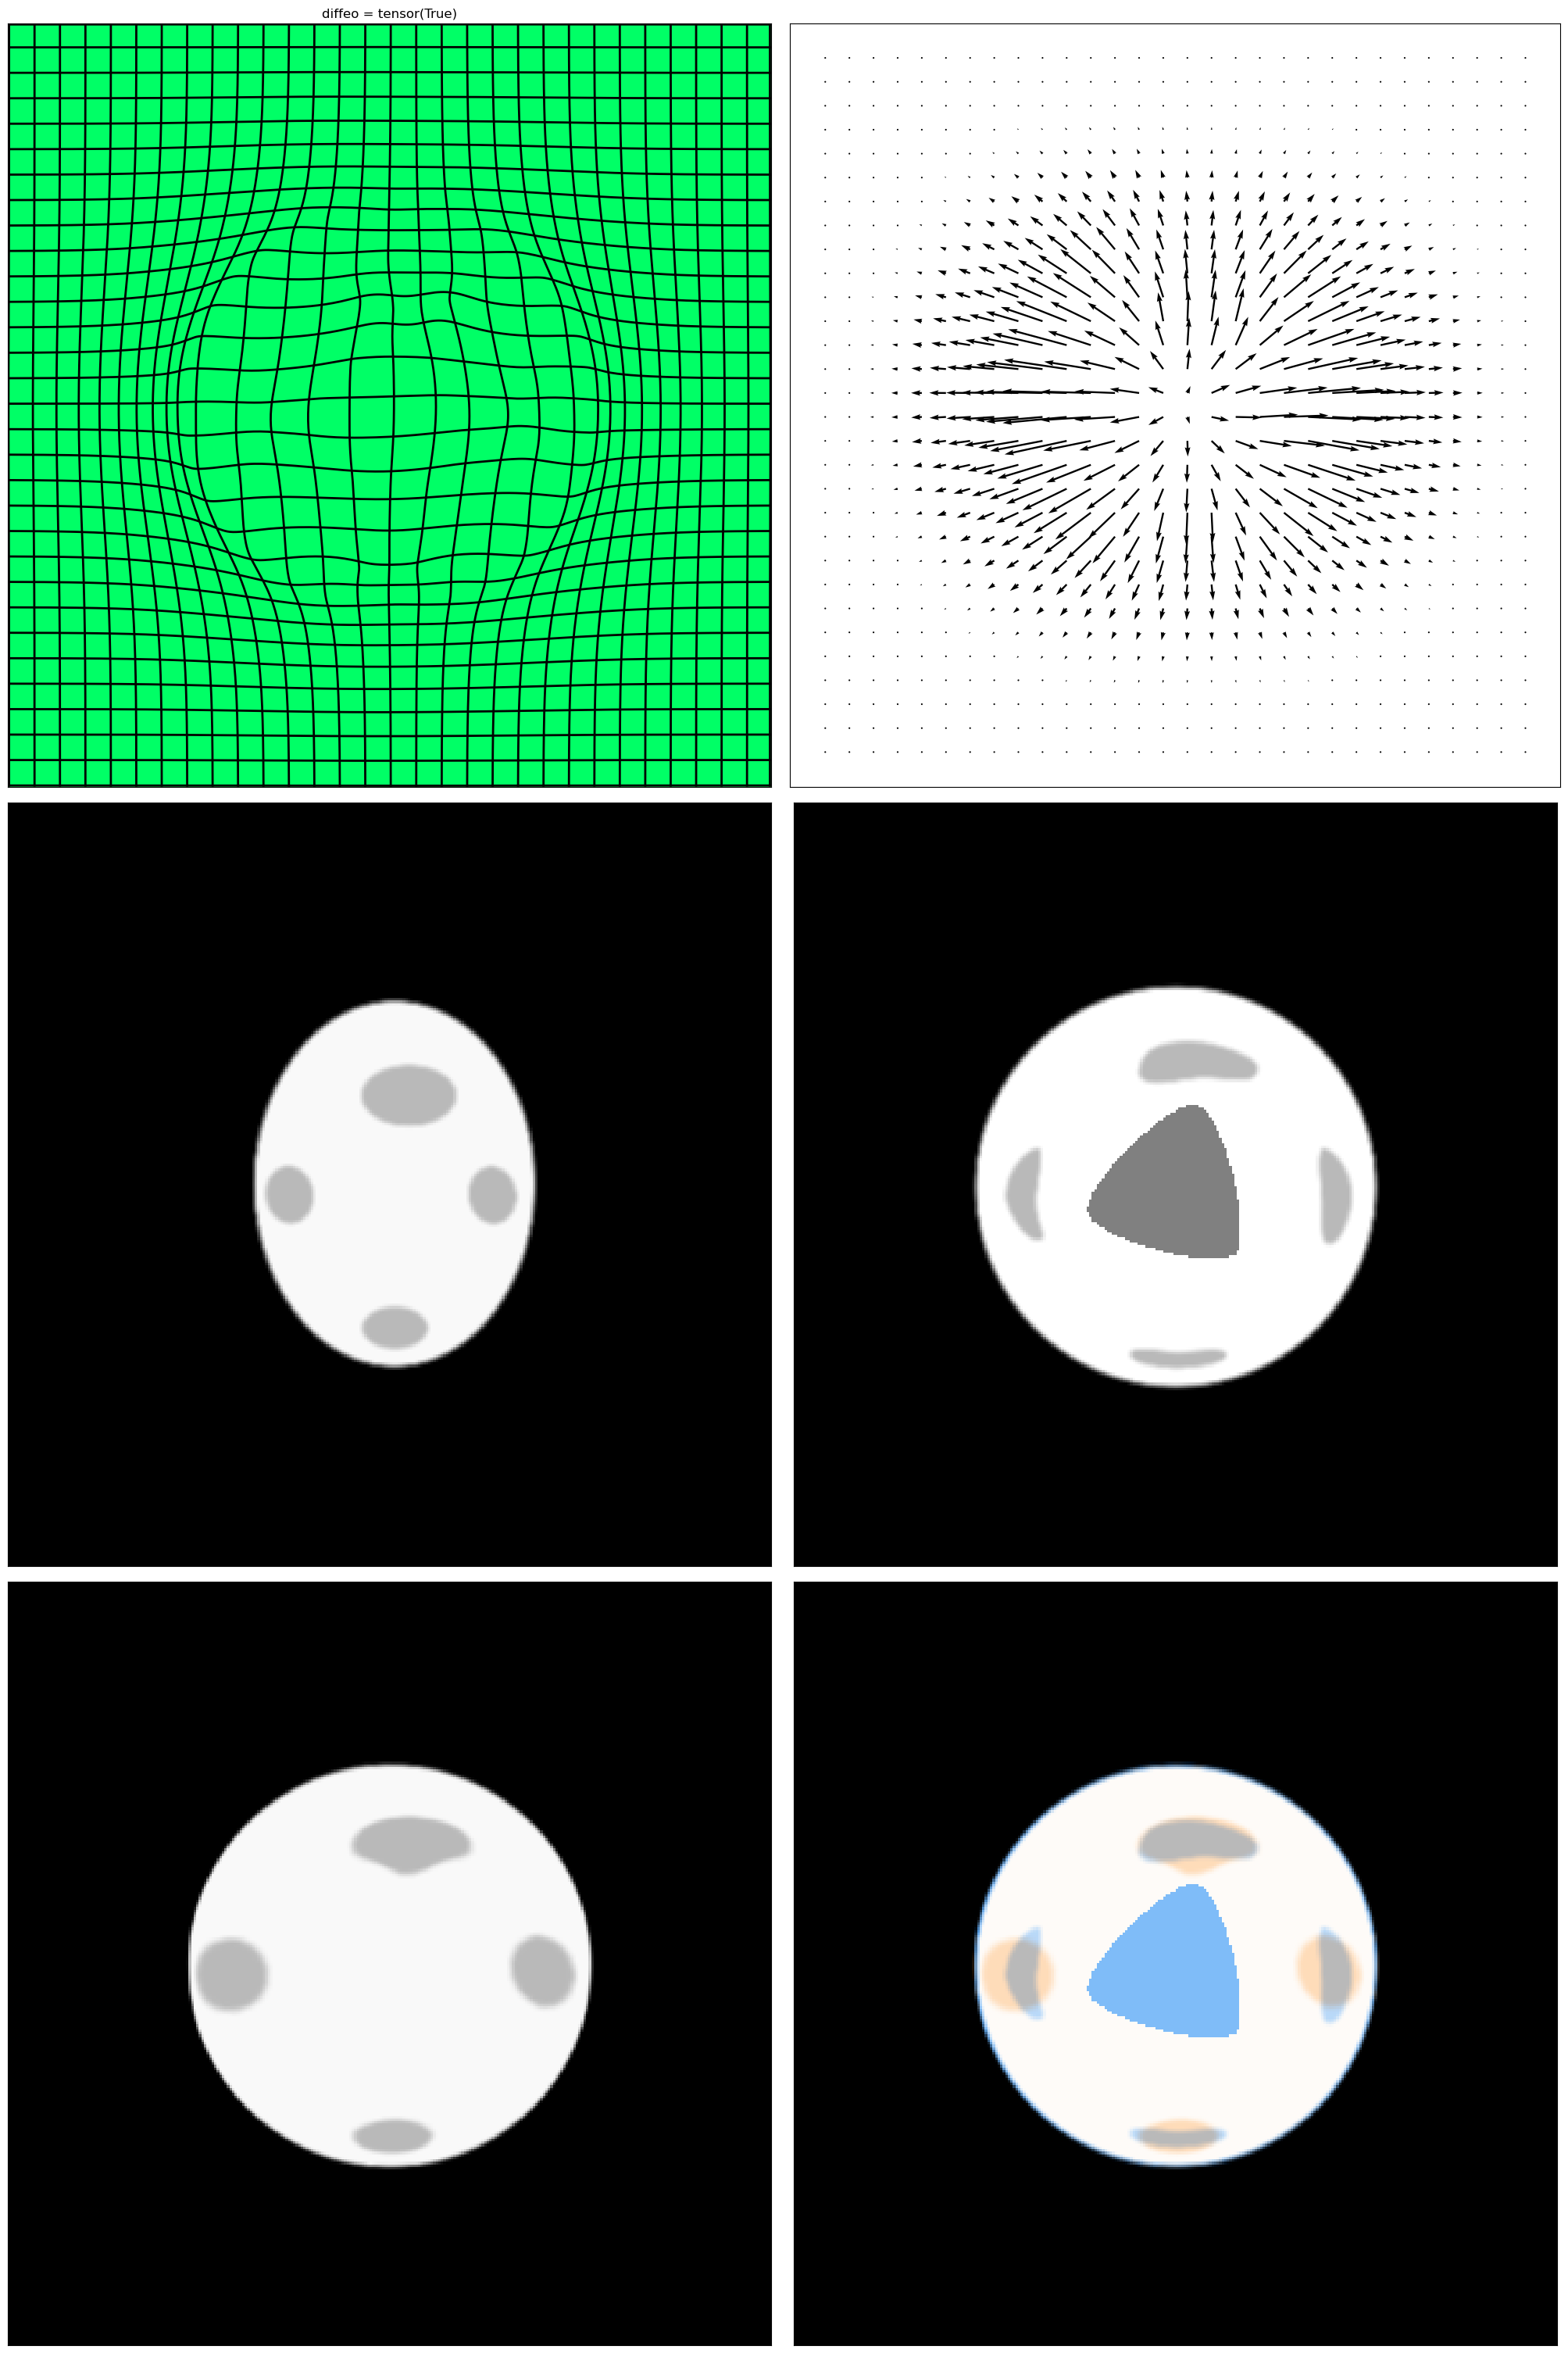

In [55]:
sigma= [(1,1),(5,5),(10,10),(30,30)]
mu = 100
n_iter= 300
grad_coef = 5e-2
residuals = 0
# residuals = mr_wm.to_analyse[0].clone().to(device)
mr_wm = mt.weighted_metamorphosis(source,target,residuals,mask,
                    mu,rho,'identity',sigma,lamb,
                    n_iter,grad_coef,
                    safe_mode=False,
                    dx_convention='square',
                    # optimizer_method='LBFGS_torch'
                    optimizer_method='adadelta'                                  
                                  )
mr_wm.plot(False)
mr_wm.mp.plot()
mr_wm.plot_deform()

Annimation :
<img src="gifs/playExample_MetaMask.gif" width="500" align="center">